In [1]:
%%capture
%load_ext autoreload
%autoreload 2

In [2]:
import tqdm

In [3]:
!pip install scikit-surprise

In [4]:
!pip install ipywidgets --upgrade

## Generate Logged Dataset

In [6]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

In [7]:
np.random.seed(0)

In [104]:
NUM_SOURCES = 3
NUM_ACTIONS = 2
NUM_SAMPLES = [1_000] * NUM_SOURCES
NUM_FEATURES = 4


def create_multi_task_bandit_dataset_with_action_dependent_context(
        num_interactions=500,
        num_tasks=NUM_SOURCES, 
        num_actions=NUM_ACTIONS, 
        num_context_dims=NUM_FEATURES,  
        sigma_q=1.0,        # Controls hyperparameter uncertainty
        sigma_0=5.0,        # Task covariance
        reward_noise=1.0    # Reward noise
):
    
    # Hyperprior mean and covariance (for sampling mu*)
    mu_prior_mean = np.zeros(num_context_dims)
    mu_prior_cov = np.eye(num_context_dims) * sigma_q**2

    # Sample hyperparameter mu*
    mu_star = np.random.multivariate_normal(mu_prior_mean, mu_prior_cov)

    # Task-specific parameters theta_s* (sampled for each task)
    task_params = []
    task_cov = np.eye(num_context_dims) * sigma_0**2
    for _ in range(num_tasks):
        theta_s_star = np.random.multivariate_normal(mu_star, task_cov)
        task_params.append(theta_s_star)
    
    task_params = np.array(task_params)  # Shape: (num_tasks, num_context_dims)

    # Generate the dataset
    data = {}

    for task_id in range(num_tasks):
        task_data = {
            'contexts': [],
            'actions': [],
            'rewards': [],
            'true_rewards': []
        }

        if task_id == NUM_SOURCES - 1:
            theta_s_star = task_params[task_id]
        else:
            theta_s_star = task_params[0]

        for t in range(num_interactions):
            # Generate a context-action vector for each action (action-dependent context)
            context_action_vectors = np.random.uniform(-1, 1, (num_actions, num_context_dims))

            # Compute true rewards for all actions: φ(x, a) ^ T θ_s*
            true_rewards = 2 * (1 + np.dot(context_action_vectors, theta_s_star))

            # Sample a random action
            if t < 2 * NUM_ACTIONS:
                action = t % NUM_ACTIONS
            else:
                action = np.random.choice(num_actions)

            # Observe the reward for the selected action with noise
            observed_reward = np.random.normal(true_rewards[action], reward_noise)

            # Store the context (the selected action's context vector), reward, action, and true rewards vector
            task_data['contexts'].append(context_action_vectors[action])
            task_data['actions'].append(str(action))
            task_data['rewards'].append(observed_reward)
            task_data['true_rewards'].append(true_rewards)

        print(np.mean(task_data["true_rewards"], axis=0))
        
        # Convert lists to numpy arrays for easier manipulation later
        data[task_id] = [np.array(task_data['contexts']), np.array(task_data['rewards']), task_data['actions'], np.array(task_data['true_rewards'])]

    # return data, task_params, mu_star
    return data

In [105]:
# Create observational dataset
# NUM_SOURCES = num_tasks
N = 500
train_data = create_multi_task_bandit_dataset_with_action_dependent_context(num_interactions=N)
eval_data = create_multi_task_bandit_dataset_with_action_dependent_context(num_interactions=2*N)
test_data = create_multi_task_bandit_dataset_with_action_dependent_context(num_interactions=100)

[1.63270752 1.83021531]
[1.97250494 1.74895671]
[1.98540221 2.04939406]
[2.06297976 1.93573163]
[1.90329286 1.89481724]
[1.98847997 1.95475243]
[ 1.87098328 -0.49651599]
[1.03480288 1.37694125]
[0.39865841 1.14527323]


# Run Experiments

In [106]:
from src.egpolicytree import EGPolicyTree
from src import utils

# Local policies

In [15]:
def subsample_data(data, sample_size):
        num_samples = data[0].shape[0]
        if num_samples < sample_size:
            raise ValueError(f"Sample size {sample_size} is larger than the dataset size for source_id {source_id}")
        
        indices = np.array(random.sample(range(num_samples), sample_size))
        # print(indices)
        subsampled_dataset = []
        for arr in data:
            arr_sub = np.array([arr[i] for i in indices])
            subsampled_dataset.append(arr_sub)

        return subsampled_dataset

In [114]:
import numpy as np
import matplotlib.pyplot as plt
# import rpy2.robjects as ro
# from rpy2.robjects import numpy2ri, rvectors
# import grf
# import policytree
# import utils
import pandas as pd  # For rolling average calculation

# # Ensure conversion between numpy and R types
# numpy2ri.activate()
NUM_SEEDS = 2

# Range of subsample sizes
subsample_sizes = np.arange(10, 501, 10)  # Adjust step size as needed
# NUM_SOURCES = 3  # Example value, update with the actual number of sources

# Initialize dictionaries to store policy, best policy, and regret values for each source
policy_values_dict = {source_id: [] for source_id in range(NUM_SOURCES)}
best_policy_values_dict = {source_id: [] for source_id in range(NUM_SOURCES)}
regret_values_dict = {source_id: np.zeros((NUM_SEEDS, len(subsample_sizes))) for source_id in range(2*NUM_SOURCES)}
mixture_regret_values_dict = {source_id: np.zeros((NUM_SEEDS, len(subsample_sizes))) for source_id in range(2*NUM_SOURCES)}

# # Default span is the largest x value
# span = 20

# Define a smoothing function using a rolling window average
def smooth_values(values, span):
    values_series = pd.Series(values)
    return values_series.rolling(window=span, min_periods=1, center=True).mean().tolist()

best_policy_values_dict = {}


for seed in range(NUM_SEEDS):
    # Loop through each source and subsample size
    for source_id in range(NUM_SOURCES):
    
        train_data_i = train_data[source_id]
        eval_covariates, eval_rewards, eval_treatment, eval_true_rewards = train_data[source_id]
        # test_covariates, test_rewards, test_treatment, test_true_rewards = test_data[source_id]
    
        # Convert data to R objects
        eval_covariates_r = numpy2ri.py2rpy(eval_covariates)          # ns x p
        eval_rewards_r = rvectors.FloatVector(eval_rewards)           # ns x 1
        eval_treatment_r = rvectors.FactorVector(eval_treatment)      # ns x 1
        eval_true_rewards_r = numpy2ri.py2rpy(eval_true_rewards)
        best_policy = policytree.policy_tree(eval_covariates_r, eval_true_rewards_r, depth=2)
    
        # Train multi-arm causal forest
        multiforest = grf.multi_arm_causal_forest(eval_covariates_r, eval_rewards_r, eval_treatment_r)
        
        # Calculate double robust scores
        eval_scores = np.array(policytree.double_robust_scores(multiforest)) # ns x d
    
        # Train and evaluate the best policy (using true rewards)
        # true_rewards_r = numpy2ri.py2rpy(true_rewards)
        best_policy_value = utils.evaluate_policy(best_policy, eval_covariates, eval_scores, best=True)
        # best_policy_values_dict[source_id].append(best_policy_value)  # Store the best policy value
        print(best_policy_value)
    
        # best_policy_values_dict[source_id] = best_policy_value
        
        for i, subsample_size in enumerate(subsample_sizes):
            # Subsample the data
            # covariates, rewards, treatment, true_rewards = subsample_data(train_data[0], subsample_size)
            covariates, rewards, treatment, true_rewards = subsample_data(train_data[source_id], subsample_size)
            
            # Convert data to R objects
            covariates_r = numpy2ri.py2rpy(covariates)          # ns x p
            rewards_r = rvectors.FloatVector(-rewards)          # ns x 1
            treatment_r = rvectors.FactorVector(treatment)      # ns x 1
            
            # Train multi-arm causal forest
            multiforest = grf.multi_arm_causal_forest(covariates_r, rewards_r, treatment_r)
            
            # Calculate double robust scores
            scores = np.array(policytree.double_robust_scores(multiforest)) # ns x d
            scores_r = numpy2ri.py2rpy(scores)
            
            # Train policy tree
            policy = policytree.policy_tree(covariates_r, scores_r, depth=2)
    
            # Evaluate policy
            policy_value = utils.evaluate_policy(policy, eval_covariates, eval_scores)
            policy_values_dict[source_id].append(policy_value)  # Store the policy value for this source and subsample size
            
            # Calculate regret (best policy value - policy value)
            regret_value = policy_value
            regret_values_dict[source_id][seed, i] = best_policy_value - regret_value  # Store the regret value

            mixture_regret_values_dict[source_id][seed, i] = utils.compute_mixture_regret(
                policy, policy, [.05, .05, .9], train_data
            )
    
            regret_values_dict[source_id+NUM_SOURCES][seed, i] = best_policy_value - utils.evaluate_random_policy(eval_covariates, eval_scores)

local_regret_values_dict = regret_values_dict

3.096666500298674
3.9454596991139996
4.586263927928836
3.1031019392144903
3.96459795102172
4.575578971024643


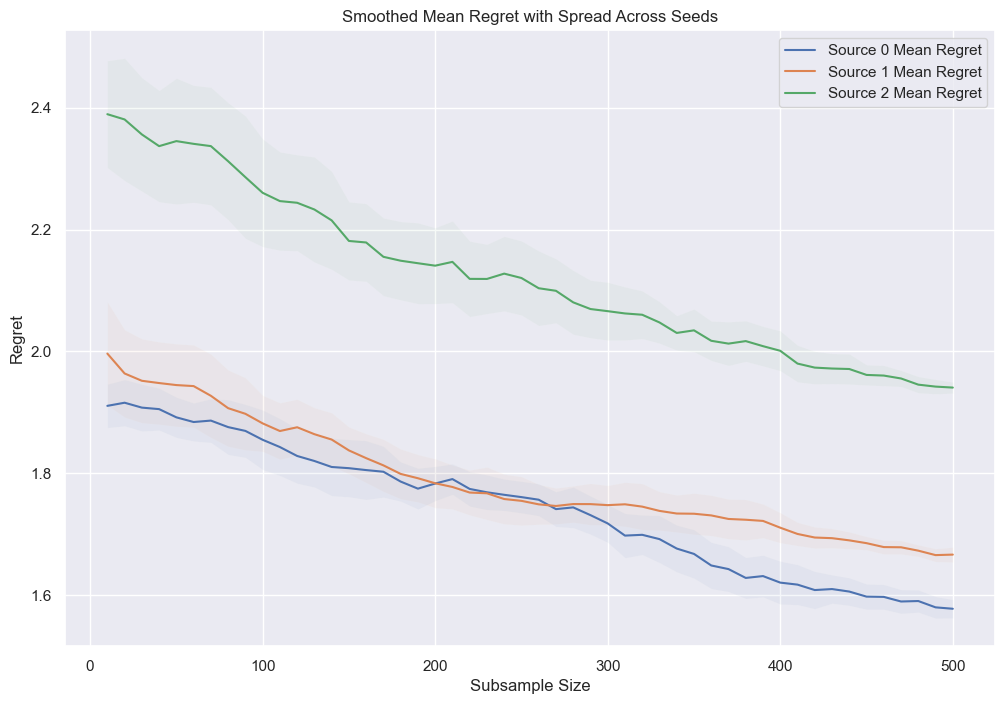

In [115]:
# Calculate mean and standard deviation across seeds for each source
mean_regret = {source_id: np.mean(local_regret_values_dict[source_id], axis=0) for source_id in range(NUM_SOURCES)}
std_regret = {source_id: np.std(local_regret_values_dict[source_id], axis=0) for source_id in range(NUM_SOURCES)}

# Span for the rolling window smoothing
span = 10

# Apply smoothing to both the mean and standard deviation using the rolling average function
smooth_mean_regret = {source_id: smooth_values(mean_regret[source_id], span) for source_id in range(NUM_SOURCES)}
smooth_std_regret = {source_id: smooth_values(std_regret[source_id], span) for source_id in range(NUM_SOURCES)}

# Plot the results with smoothed mean and spread across seeds
plt.figure(figsize=(12, 8))

for source_id in range(NUM_SOURCES):
    # Plot smoothed mean regret with shaded smoothed standard deviation
    plt.plot(subsample_sizes, smooth_mean_regret[source_id], label=f'Source {source_id} Mean Regret', linestyle='-')
    plt.fill_between(subsample_sizes, 
                     np.array(smooth_mean_regret[source_id]) - np.array(smooth_std_regret[source_id]),
                     np.array(smooth_mean_regret[source_id]) + np.array(smooth_std_regret[source_id]), 
                     alpha=0.05)

# Add legend and labels
plt.xlabel('Subsample Size')
plt.ylabel('Regret')
plt.title('Smoothed Mean Regret with Spread Across Seeds')
plt.legend(loc='upper right')  # Position the legend in the upper right corner (adjust as needed)
plt.grid(True)
plt.show()


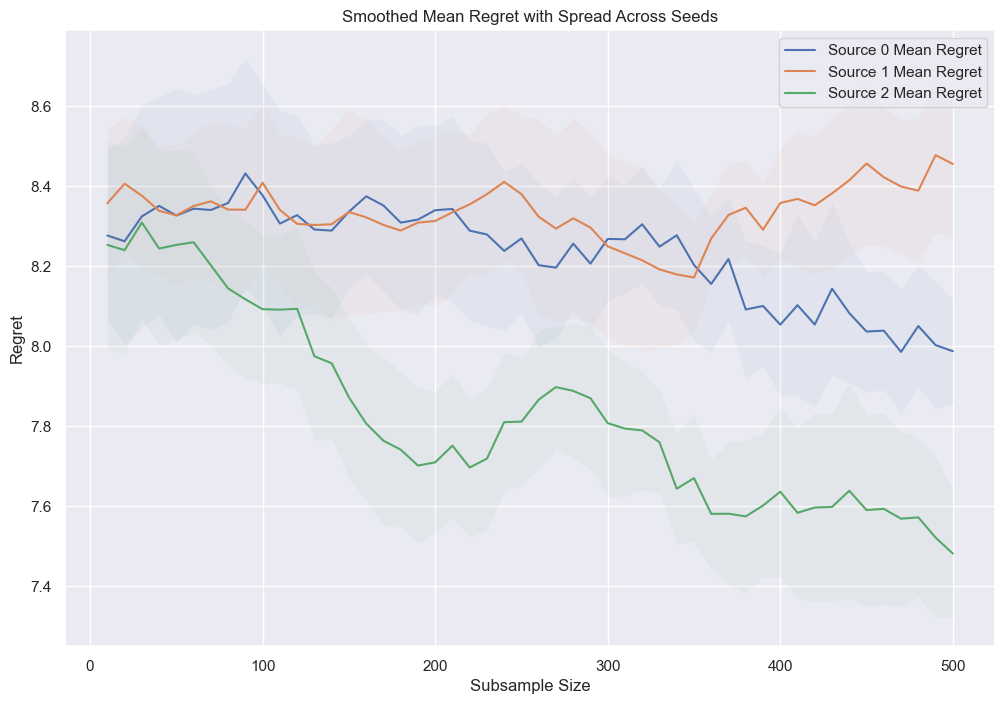

In [116]:
# Calculate mean and standard deviation across seeds for each source
mean_regret = {source_id: np.mean(mixture_regret_values_dict[source_id], axis=0) for source_id in range(NUM_SOURCES)}
std_regret = {source_id: np.std(mixture_regret_values_dict[source_id], axis=0) for source_id in range(NUM_SOURCES)}

# Span for the rolling window smoothing
span = 10

# Apply smoothing to both the mean and standard deviation using the rolling average function
smooth_mean_regret = {source_id: smooth_values(mean_regret[source_id], span) for source_id in range(NUM_SOURCES)}
smooth_std_regret = {source_id: smooth_values(std_regret[source_id], span) for source_id in range(NUM_SOURCES)}

# Plot the results with smoothed mean and spread across seeds
plt.figure(figsize=(12, 8))

for source_id in range(NUM_SOURCES):
    # Plot smoothed mean regret with shaded smoothed standard deviation
    plt.plot(subsample_sizes, smooth_mean_regret[source_id], label=f'Source {source_id} Mean Regret', linestyle='-')
    plt.fill_between(subsample_sizes, 
                     np.array(smooth_mean_regret[source_id]) - np.array(smooth_std_regret[source_id]),
                     np.array(smooth_mean_regret[source_id]) + np.array(smooth_std_regret[source_id]), 
                     alpha=0.05)

# Add legend and labels
plt.xlabel('Subsample Size')
plt.ylabel('Regret')
plt.title('Smoothed Mean Regret with Spread Across Seeds')
plt.legend(loc='upper right')  # Position the legend in the upper right corner (adjust as needed)
plt.grid(True)
plt.show()


# Global policy

In [131]:
# import numpy as np
# import matplotlib.pyplot as plt
# import rpy2.robjects as ro
# from rpy2.robjects import numpy2ri, rvectors
# import grf
# import policytree
# import utils
# import pandas as pd  # For rolling average calculation

# # Ensure conversion between numpy and R types
# numpy2ri.activate()

# Range of subsample sizes
subsample_sizes = np.arange(10, 501, 10)  # Adjust step size as needed
# NUM_SOURCES = 3  # Example value, update with the actual number of sources

# Initialize lists to store policy, best policy, and regret values (combined data)
policy_values_combined = []
best_policy_values_combined = []
regret_values_combined = []

combined_regret_values_dict = {source_id: np.zeros((NUM_SEEDS, len(subsample_sizes))) for source_id in range(NUM_SOURCES)}
combined_mixture_regret_values = np.zeros((NUM_SEEDS, len(subsample_sizes)))


# Default span is the largest x value
# span = subsample_sizes[-1]

# Define a smoothing function using a rolling window average
# def smooth_values(values, span):
#     values_series = pd.Series(values)
#     return values_series.rolling(window=span, min_periods=1, center=True).mean().tolist()

# Combine data from all sources
all_covariates = np.vstack([train_data[i][0] for i in range(NUM_SOURCES)])  # Combine covariates
all_rewards = np.hstack([train_data[i][1] for i in range(NUM_SOURCES)])     # Combine rewards
all_treatment = np.hstack([train_data[i][2] for i in range(NUM_SOURCES)])   # Combine treatment
all_true_rewards = np.vstack([train_data[i][3] for i in range(NUM_SOURCES)])# Combine true rewards

print(all_covariates.shape)
print(all_rewards.shape)
print(all_treatment.shape)
print(all_true_rewards.shape)

# Convert combined data to R objects
covariates_r = numpy2ri.py2rpy(all_covariates)        # ns x p
rewards_r = rvectors.FloatVector(all_rewards)         # ns x 1
treatment_r = rvectors.FactorVector(all_treatment)    # ns x 1
true_rewards_r = numpy2ri.py2rpy(all_true_rewards)

# Train multi-arm causal forest on the combined data
multiforest = grf.multi_arm_causal_forest(covariates_r, rewards_r, treatment_r)

# Calculate double robust scores for the combined data
scores = np.array(policytree.double_robust_scores(multiforest))  # ns x d
scores_r = numpy2ri.py2rpy(scores)

# Train the best policy on the combined data using true rewards
best_policy = policytree.policy_tree(covariates_r, scores_r, depth=2)
best_policy_value = utils.evaluate_policy(best_policy, all_covariates, scores, best=True)

for seed in range(NUM_SEEDS):
    # Loop through each subsample size and evaluate policies
    for i, subsample_size in enumerate(subsample_sizes):
        # Subsample the combined data
        subsampled_covariates, subsampled_rewards, subsampled_treatment, subsampled_true_rewards = subsample_data(
            (all_covariates, all_rewards, all_treatment, all_true_rewards), max(10,int(subsample_size/NUM_SOURCES))
        )
        
        
        # Convert subsampled data to R objects
        subsampled_covariates_r = numpy2ri.py2rpy(subsampled_covariates)  # ns x p
        subsampled_rewards_r = rvectors.FloatVector(-subsampled_rewards)   # ns x 1
        subsampled_treatment_r = rvectors.FactorVector(subsampled_treatment)  # ns x 1
    
        # Train multi-arm causal forest on the combined data
        multiforest = grf.multi_arm_causal_forest(subsampled_covariates_r, subsampled_rewards_r, subsampled_treatment_r)
        
        # Calculate double robust scores for the combined data
        subsampled_scores = np.array(policytree.double_robust_scores(multiforest))  # ns x d
        subsampled_scores_r = numpy2ri.py2rpy(subsampled_scores)
            
        # Train policy tree on the subsampled data
        policy = policytree.policy_tree(subsampled_covariates_r, subsampled_scores_r, depth=2)
        
        # # Evaluate policy
        # policy_value = utils.evaluate_policy(policy, all_covariates, scores)
        # policy_values_combined.append(policy_value)  # Store the policy value
        
        # # Calculate regret (best policy value - policy value)
        # regret_value = best_policy_value - policy_value
        # regret_values_combined.append(regret_value)  # Store the regret value
    
        for source_id in range(NUM_SOURCES):
            eval_covariates, eval_rewards, eval_treatment, eval_true_rewards = train_data[source_id]
    
            # Convert data to R objects
            eval_covariates_r = numpy2ri.py2rpy(eval_covariates)          # ns x p
            eval_rewards_r = rvectors.FloatVector(eval_rewards)           # ns x 1
            eval_treatment_r = rvectors.FactorVector(eval_treatment)      # ns x 1
            eval_true_rewards_r = numpy2ri.py2rpy(eval_true_rewards)
            best_policy = policytree.policy_tree(eval_covariates_r, eval_true_rewards_r, depth=2)
        
            # Train multi-arm causal forest
            multiforest = grf.multi_arm_causal_forest(eval_covariates_r, eval_rewards_r, eval_treatment_r)
            
            # Calculate double robust scores
            eval_scores = np.array(policytree.double_robust_scores(multiforest)) # ns x d
        
            # Train and evaluate the best policy (using true rewards)
            # true_rewards_r = numpy2ri.py2rpy(true_rewards)
            best_policy_value = utils.evaluate_policy(best_policy, eval_covariates, eval_scores, best=True)
            # best_policy_values_dict[source_id].append(best_policy_value)  # Store the best policy value
            # print(best_policy_value)
            
            # Evaluate policy
            policy_value = utils.evaluate_policy(policy, eval_covariates, eval_scores)
            policy_values_dict[source_id].append(policy_value)  # Store the policy value for this source and subsample size
            
            # Calculate regret (best policy value - policy value)
            regret_value = policy_value
            combined_regret_values_dict[source_id][seed, i] = best_policy_value - regret_value  # Store the regret value

        combined_mixture_regret_values[seed, i] = utils.compute_mixture_regret(
                policy, policy, [.05, .05, .9], train_data
            )

(1500, 4)
(1500,)
(1500,)
(1500, 2)


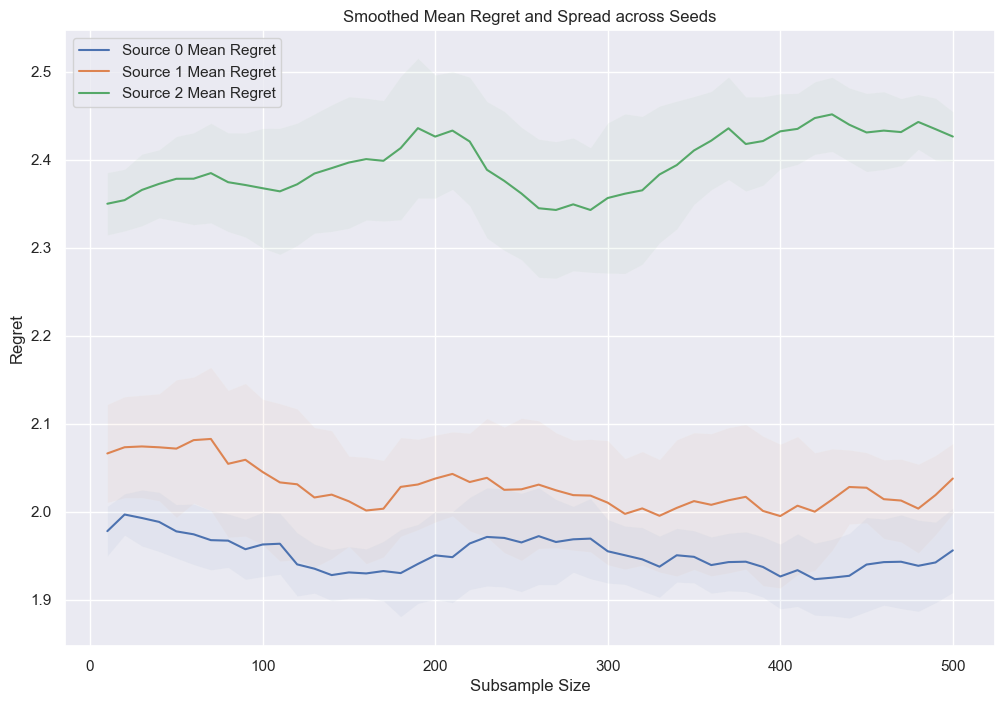

In [132]:
span = 10

mean_regret = {source_id: np.mean(combined_regret_values_dict[source_id], axis=0) for source_id in range(NUM_SOURCES)}
std_regret = {source_id: np.std(combined_regret_values_dict[source_id], axis=0) for source_id in range(NUM_SOURCES)}

smooth_mean_regret = {source_id: smooth_values(mean_regret[source_id], span) for source_id in range(NUM_SOURCES)}
smooth_std_regret = {source_id: smooth_values(std_regret[source_id], span) for source_id in range(NUM_SOURCES)}

plt.figure(figsize=(12, 8))

for source_id in range(NUM_SOURCES):
    plt.plot(subsample_sizes, smooth_mean_regret[source_id], label=f'Source {source_id} Mean Regret', linestyle='-')
    plt.fill_between(subsample_sizes, 
                     np.array(smooth_mean_regret[source_id]) - np.array(smooth_std_regret[source_id]),
                     np.array(smooth_mean_regret[source_id]) + np.array(smooth_std_regret[source_id]), 
                     alpha=0.05)

plt.xlabel('Subsample Size')
plt.ylabel('Regret')
plt.title('Smoothed Mean Regret and Spread across Seeds')
plt.legend()
plt.grid(True)
plt.show()

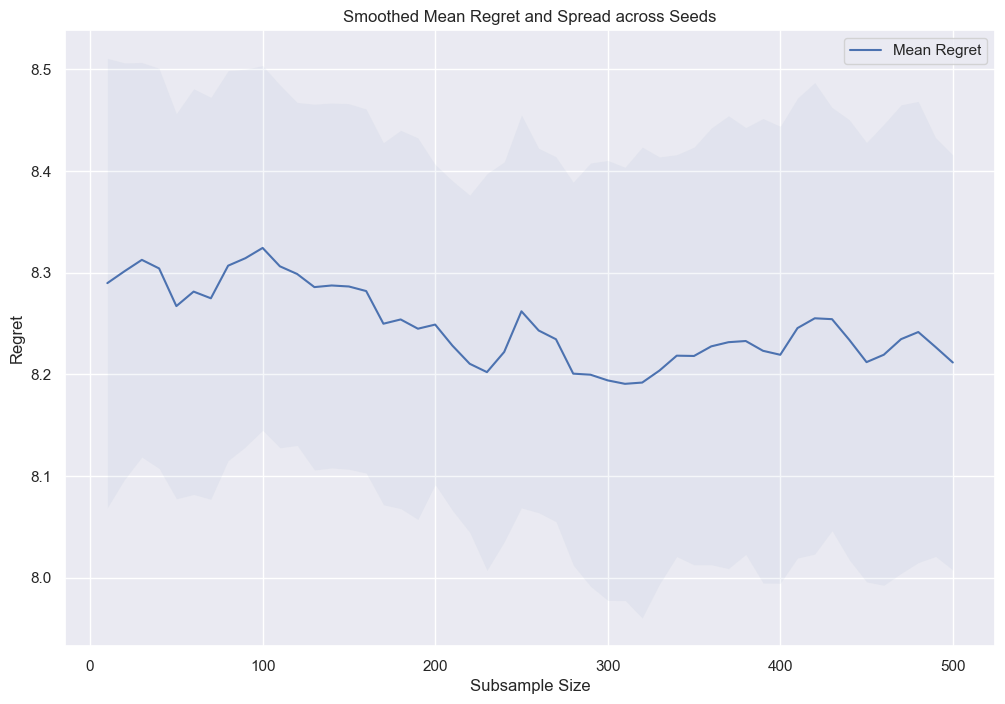

In [133]:
span = 20

mean_regret = np.mean(combined_mixture_regret_values, axis=0)
std_regret = np.std(combined_mixture_regret_values, axis=0)

smooth_mean_regret = smooth_values(mean_regret, span)
smooth_std_regret = smooth_values(std_regret, span)

plt.figure(figsize=(12, 8))

plt.plot(subsample_sizes, smooth_mean_regret, label=f'Mean Regret', linestyle='-')
plt.fill_between(subsample_sizes, 
                 np.array(smooth_mean_regret) - np.array(smooth_std_regret),
                 np.array(smooth_mean_regret) + np.array(smooth_std_regret), 
                 alpha=0.05)

plt.xlabel('Subsample Size')
plt.ylabel('Regret')
plt.title('Smoothed Mean Regret and Spread across Seeds')
plt.legend()
plt.grid(True)
plt.show()

# EG Policy Tree

In [144]:
subsample_sizes = np.arange(10, 501, 10)
cover = []
num_weights = NUM_SOURCES
for i in range(num_weights):
    distribution = np.zeros(num_weights)
    distribution[i] = 1
    cover.append(distribution)
print(cover)

def run_experiments(
    num_subsamples_list, 
    cover, 
    train_data, 
    test_data, 
):
    results = []
    num_weights = len(cover)

    mixture_results = []

    for num_subsamples in num_subsamples_list:
        expert_mixture_regrets = [[] for _ in range(2*num_weights)]
        mixture_regrets = []
        num_iterations = max(10, num_subsamples)
        learning_rate = np.sqrt(np.log(num_weights) / (num_iterations * 10))

        num_repetitions = 2
        for _ in range(num_repetitions):
            # Initialize and train the policy
            egpolicytree = EGPolicyTree(cover, learning_rate, depth=2)
            egpolicytree.fit(train_data,
                             num_iterations=int(np.pow(num_iterations, 1/2)),
                             num_subsamples=max(10,int(num_subsamples))
                            )

            print(egpolicytree.trained_policy)

            # Compute mixture regrets for each expert
            for expert_id in range(NUM_SOURCES):
                mixture_weights = cover[expert_id]

                eval_covariates, eval_rewards, eval_treatment, eval_true_rewards = train_data[expert_id]
                # test_covariates, test_rewards, test_treatment, test_true_rewards = test_data[source_id]
            
                # Convert data to R objects
                eval_covariates_r = numpy2ri.py2rpy(eval_covariates)          # ns x p
                eval_rewards_r = rvectors.FloatVector(eval_rewards)           # ns x 1
                eval_treatment_r = rvectors.FactorVector(eval_treatment)      # ns x 1
                eval_true_rewards_r = numpy2ri.py2rpy(eval_true_rewards)
                best_policy = policytree.policy_tree(eval_covariates_r, eval_true_rewards_r, depth=2)
            
                # Train multi-arm causal forest
                multiforest = grf.multi_arm_causal_forest(eval_covariates_r, eval_rewards_r, eval_treatment_r)
                
                # Calculate double robust scores
                eval_scores = np.array(policytree.double_robust_scores(multiforest)) # ns x d
                
                # mixture_regret = utils.compute_mixture_regret(
                #     egpolicytree.trained_policy, 
                #     optimal_policy,
                #     mixture_weights,
                #     train_data
                # )
                mixture_regret = utils.compute_regret(
                    egpolicytree.trained_policy, 
                    egpolicytree.trained_policy,
                    eval_covariates,
                    eval_scores
                )
                expert_mixture_regrets[expert_id].append(mixture_regret)

                # random_regret = utils.compute_mixture_regret_random(mixture_weights, train_data)
                
                random_regret = best_policy_value - utils.evaluate_random_policy(eval_covariates, eval_scores)
                expert_mixture_regrets[expert_id+NUM_SOURCES].append(random_regret)

            mixture_regrets.append(
                utils.compute_mixture_regret(
                    egpolicytree.trained_policy, egpolicytree.trained_policy, [.05, .05, .9], train_data
                )
            )

        for expert_id in range(2*num_weights):
            mean_regret = np.mean(expert_mixture_regrets[expert_id])
            std_regret = np.std(expert_mixture_regrets[expert_id])
            results.append((num_subsamples, expert_id, mean_regret, std_regret))

        mixture_mean_regret = np.mean(mixture_regrets)
        mixture_std_regret = np.std(mixture_regrets)
        mixture_results.append((num_subsamples, mixture_mean_regret, mixture_std_regret))
    
    return results, mixture_results

[array([1., 0., 0.]), array([0., 1., 0.]), array([0., 0., 1.])]


In [145]:
# Define parameters
# num_subsamples_list = [x for x in range(20, 201, 1)]  # Example subsample sizes

# num_repetitions = 1
# cover = np.random.rand(10, 10)  # Replace with actual cover
# learning_rate = 0.1
# learning_rate = np.sqrt(np.log(num_weights) / (num_subsamples * 10))
# data = np.random.rand(100, 10)  # Replace with actual data
# eval_data = np.random.rand(20, 10)  # Replace with actual eval data
# num_iterations = None
# num_weights = 10

# Run experiments
results, mixture_results = run_experiments(
    subsample_sizes, 
    cover, 
    train_data, 
    test_data, 
)


Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 11.683577771107089
INFO:src.egpolicytree:Iteration 0: Gradients: [-2.88205623 -3.80970908 -3.80975228]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.35525729 0.32237209 0.32237063]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 7.120655054875053
INFO:src.egpolicytree:Iteration 1: Gradients: [-2.88205623 -3.80970908 -3.80975228]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.35525729 0.32237209 0.32237063]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.37571047 0.31214611 0.31214342]
INFO:src.egpolicytree:Best response policy created 

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X2  split_value: 0.178188 
  (2) split_variable: X4  split_value: 0.236326 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X4  split_value: -0.221376 
    (6) * action: 2 
    (7) * action: 1 



Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                         | 0/3 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 7.572888400913159
INFO:src.egpolicytree:Iteration 0: Gradients: [-1.91142332 -8.40145437  0.        ]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.36649346 0.18578977 0.44771677]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 5.8014903975288785
INFO:src.egpolicytree:Iteration 1: Gradients: [-1.91142332 -8.40145437  0.        ]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.36649346 0.18578977 0.44771677]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.36509048 0.09996272 0.5349468 ]
INFO:src.egpolicytree:Best response policy created 

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X4  split_value: 0.375805 
  (2) split_variable: X3  split_value: -0.277313 
    (4) * action: 2 
    (5) * action: 1 
  (3) split_variable: X1  split_value: -0.219721 
    (6) * action: 2 
    (7) * action: 1 



Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                         | 0/4 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.266214203079397
INFO:src.egpolicytree:Iteration 0: Gradients: [-4.36005745 -5.55848316 -0.77494988]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.3106428  0.28426924 0.40508796]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 5.2399975174947455
INFO:src.egpolicytree:Iteration 1: Gradients: [-3.84653243 -6.9105749   0.        ]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.3106428  0.28426924 0.40508796]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.29122746 0.21687655 0.49189599]
INFO:src.egpolicytree:Best response policy created 

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.327271 
  (2) split_variable: X3  split_value: -0.871521 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X2  split_value: -0.695666 
    (6) * action: 2 
    (7) * action: 1 



Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                         | 0/4 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.070798016368013
INFO:src.egpolicytree:Iteration 0: Gradients: [-4.98036997 -1.63722533 -3.9505084 ]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.29761122 0.38119839 0.32119039]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.942715557732612
INFO:src.egpolicytree:Iteration 1: Gradients: [-4.98036997 -0.52470923 -5.24552521]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.29761122 0.38119839 0.32119039]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.26395902 0.45623322 0.27980777]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.664353 
  (2) split_variable: X2  split_value: 0.12639 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X2  split_value: 0.250243 
    (6) * action: 2 
    (7) * action: 1 



Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.758119401988076
INFO:src.egpolicytree:Iteration 0: Gradients: [-1.73670308 -1.00086637 -3.45503181]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33934805 0.35478519 0.30586676]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.080761232157988
INFO:src.egpolicytree:Iteration 1: Gradients: [-1.73670308 -1.00086637 -3.45503181]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33934805 0.35478519 0.30586676]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.34378377 0.37424141 0.28197482]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X2  split_value: 0.377112 
  (2) split_variable: X4  split_value: -0.340259 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X4  split_value: 0.121879 
    (6) * action: 2 
    (7) * action: 1 



Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                         | 0/5 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 9.144163147754213
INFO:src.egpolicytree:Iteration 0: Gradients: [-1.58347646 -1.80191193 -1.60070509]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33491408 0.3305205  0.33456543]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 8.379501495575223
INFO:src.egpolicytree:Iteration 1: Gradients: [-1.58347646 -1.80191193 -1.60070509]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33491408 0.3305205  0.33456543]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33634559 0.3279766  0.33567781]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X2  split_value: 0.450548 
  (2) split_variable: X4  split_value: -0.0509625 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: 0.292273 
    (6) * action: 1 
    (7) * action: 2 



Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                         | 0/6 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.079864698626712
INFO:src.egpolicytree:Iteration 0: Gradients: [-1.55614532 -2.73475347 -1.25800482]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33830733 0.3180631  0.34362957]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.967444506981531
INFO:src.egpolicytree:Iteration 1: Gradients: [-1.55614532 -2.73475347 -1.25800482]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33830733 0.3180631  0.34362957]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.34256381 0.30451557 0.35292062]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X4  split_value: 0.0590163 
  (2) split_variable: X2  split_value: 0.814502 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X4  split_value: 0.222407 
    (6) * action: 2 
    (7) * action: 1 



Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                         | 0/6 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 7.91225024980499
INFO:src.egpolicytree:Iteration 0: Gradients: [-1.23221569 -2.10782662 -0.19093658]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33209083 0.31721101 0.35069816]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 7.4405666684570955
INFO:src.egpolicytree:Iteration 1: Gradients: [-1.23221569 -2.10782662 -0.19093658]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33209083 0.31721101 0.35069816]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33048226 0.30280444 0.3667133 ]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X2  split_value: -0.428788 
  (2) split_variable: X2  split_value: -0.826068 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X4  split_value: 0.831697 
    (6) * action: 1 
    (7) * action: 2 



Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                         | 0/7 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.340837987495014
INFO:src.egpolicytree:Iteration 0: Gradients: [-1.18137194 -1.18679164 -1.04811923]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33266737 0.33258295 0.33474968]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 7.426450274359495
INFO:src.egpolicytree:Iteration 1: Gradients: [-1.18137194 -1.18679164 -1.04811923]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33266737 0.33258295 0.33474968]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33206116 0.3319004  0.33603843]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X4  split_value: 0.0427106 
  (2) split_variable: X4  split_value: -0.903787 
    (4) * action: 2 
    (5) * action: 1 
  (3) split_variable: X1  split_value: 0.241599 
    (6) * action: 2 
    (7) * action: 1 



Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                         | 0/7 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 7.097867479662379
INFO:src.egpolicytree:Iteration 0: Gradients: [-2.17821958 -1.64092442 -0.79791351]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.32338908 0.33162872 0.34498221]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 7.477269597961177
INFO:src.egpolicytree:Iteration 1: Gradients: [-2.17821958 -1.64092442 -0.79791351]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.32338908 0.33162872 0.34498221]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.31442212 0.32988443 0.35569345]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X3  split_value: 0.527506 
  (2) split_variable: X1  split_value: -0.152232 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X4  split_value: 0.00172244 
    (6) * action: 1 
    (7) * action: 2 



Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                         | 0/7 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.709972777157772
INFO:src.egpolicytree:Iteration 0: Gradients: [-1.71646748 -1.19321857 -1.8066106 ]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33126032 0.33875337 0.32998631]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.739992150852682
INFO:src.egpolicytree:Iteration 1: Gradients: [-1.71646748 -1.19321857 -1.8066106 ]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33126032 0.33875337 0.32998631]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.32935057 0.34371154 0.3269379 ]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X4  split_value: 0.36315 
  (2) split_variable: X3  split_value: 0.760927 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X2  split_value: 0.539825 
    (6) * action: 2 
    (7) * action: 1 



Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                         | 0/7 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 7.53724316566972
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.83996734 -2.1497775  -1.02307054]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.34039645 0.3218611  0.33774245]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.249706538373519
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.83996734 -2.1497775  -1.02307054]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.34039645 0.3218611  0.33774245]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.34675871 0.31162317 0.34161812]
INFO:src.egpolicytree:Best response policy created wi

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X4  split_value: 0.642726 
  (2) split_variable: X4  split_value: -0.373658 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: -0.191534 
    (6) * action: 1 
    (7) * action: 2 



Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                         | 0/8 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.180023120202268
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.72201668 -0.81699937 -1.36082939]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33655496 0.33529219 0.32815285]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.847330201453282
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.72201668 -0.81699937 -1.36082939]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33655496 0.33529219 0.32815285]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33947122 0.33704496 0.32348382]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X4  split_value: -0.60858 
  (2) split_variable: X2  split_value: -0.10854 
    (4) * action: 2 
    (5) * action: 1 
  (3) split_variable: X1  split_value: 0.146505 
    (6) * action: 2 
    (7) * action: 1 



Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                         | 0/8 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 8.722588707460918
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.80356535 -2.11068893 -0.57140278]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33797313 0.320934   0.34109287]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 7.559392691724833
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.80356535 -2.11068893 -0.57140278]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33797313 0.320934   0.34109287]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.34203272 0.30988491 0.34808236]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X3  split_value: 0.65015 
  (2) split_variable: X1  split_value: -0.933992 
    (4) * action: 2 
    (5) * action: 1 
  (3) split_variable: X1  split_value: 0.718929 
    (6) * action: 2 
    (7) * action: 1 



Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                         | 0/8 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.064019627009716
INFO:src.egpolicytree:Iteration 0: Gradients: [-1.01459483 -0.77299861 -0.50549617]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33024991 0.3332169  0.33653319]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.773948513252453
INFO:src.egpolicytree:Iteration 1: Gradients: [-1.01459483 -0.77299861 -0.50549617]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33024991 0.3332169  0.33653319]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.32745779 0.33309408 0.33944813]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X3  split_value: -0.635855 
  (2) split_variable: X4  split_value: 0.0641305 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: 0.47095 
    (6) * action: 2 
    (7) * action: 1 



Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                         | 0/8 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 7.3901243603214875
INFO:src.egpolicytree:Iteration 0: Gradients: [-1.66350139 -0.70854329 -0.31572191]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.32392377 0.33558017 0.34049606]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.944290884647877
INFO:src.egpolicytree:Iteration 1: Gradients: [-1.66350139 -0.70854329 -0.31572191]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.32392377 0.33558017 0.34049606]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.31549069 0.3375063  0.347003  ]
INFO:src.egpolicytree:Best response policy created 

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X2  split_value: 0.0410897 
  (2) split_variable: X1  split_value: 0.676291 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X3  split_value: 0.422011 
    (6) * action: 2 
    (7) * action: 1 



Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                         | 0/9 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 5.878357218004252
INFO:src.egpolicytree:Iteration 0: Gradients: [-1.23631401 -1.24319937 -0.46837504]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33036818 0.3302888  0.33934302]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 7.001027913929239
INFO:src.egpolicytree:Iteration 1: Gradients: [-1.23631401 -1.24319937 -0.46837504]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33036818 0.3302888  0.33934302]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.32765225 0.32750204 0.34484571]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X4  split_value: -0.229805 
  (2) split_variable: X3  split_value: 0.527148 
    (4) * action: 2 
    (5) * action: 1 
  (3) split_variable: X4  split_value: 0.411181 
    (6) * action: 1 
    (7) * action: 2 



Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                         | 0/9 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.695944294716808
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.74692295 -0.54822176 -0.81414605]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33282124 0.3351375  0.33204126]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.874351427776464
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.74692295 -0.54822176 -0.81414605]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33282124 0.3351375  0.33204126]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33235242 0.33677976 0.33086782]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X4  split_value: -0.334647 
  (2) split_variable: X4  split_value: -0.574438 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X4  split_value: 0.246196 
    (6) * action: 1 
    (7) * action: 2 



Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/10 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.226478926901286
INFO:src.egpolicytree:Iteration 0: Gradients: [-1.20351396 -0.95099972 -0.59250949]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33016005 0.33293217 0.33690778]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 7.489814820202164
INFO:src.egpolicytree:Iteration 1: Gradients: [-1.20351396 -0.95099972 -0.59250949]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33016005 0.33293217 0.33690778]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.32728504 0.33254839 0.34016657]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X3  split_value: 0.10355 
  (2) split_variable: X3  split_value: -0.642024 
    (4) * action: 2 
    (5) * action: 1 
  (3) split_variable: X2  split_value: 0.875601 
    (6) * action: 2 
    (7) * action: 1 



Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/10 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.82195027292886
INFO:src.egpolicytree:Iteration 0: Gradients: [-1.1886001  -0.74668992 -0.10552291]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.32773411 0.33256493 0.33970096]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 7.148594104066458
INFO:src.egpolicytree:Iteration 1: Gradients: [-1.1886001  -0.74668992 -0.10552291]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.32773411 0.33256493 0.33970096]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.32267028 0.33180607 0.34552365]
INFO:src.egpolicytree:Best response policy created wi

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.0915818 
  (2) split_variable: X1  split_value: -0.276157 
    (4) * action: 2 
    (5) * action: 1 
  (3) split_variable: X4  split_value: 0.0992721 
    (6) * action: 1 
    (7) * action: 2 



Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/10 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 5.923390849789059
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.43299268 -0.49210156 -0.81119501]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33486632 0.33424199 0.33089169]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 7.009170892542906
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.43299268 -0.49210156 -0.81119501]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33486632 0.33424199 0.33089169]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33625652 0.33506131 0.32868216]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X3  split_value: 0.423803 
  (2) split_variable: X4  split_value: -0.0185834 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X3  split_value: 0.752536 
    (6) * action: 1 
    (7) * action: 2 



Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/10 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.151596483342914
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.58741844 -0.7265284  -0.4142264 ]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33321108 0.33175088 0.33503804]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 7.458054710696663
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.58741844 -0.7265284  -0.4142264 ]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33321108 0.33175088 0.33503804]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33309541 0.33031572 0.33658888]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X2  split_value: -0.233327 
  (2) split_variable: X3  split_value: -0.877487 
    (4) * action: 2 
    (5) * action: 1 
  (3) split_variable: X1  split_value: -0.30048 
    (6) * action: 2 
    (7) * action: 1 



Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/10 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.5561962637527085
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.91269628 -0.69623575 -0.0427148 ]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.3296837  0.33184787 0.33846843]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.723253912154769
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.91269628 -0.69623575 -0.0427148 ]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.3296837  0.33184787 0.33846843]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.3263686  0.33046865 0.34316275]
INFO:src.egpolicytree:Best response policy created 

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.277713 
  (2) split_variable: X1  split_value: -0.814555 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: 0.766585 
    (6) * action: 1 
    (7) * action: 2 



Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/10 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 7.034287544947733
INFO:src.egpolicytree:Iteration 0: Gradients: [-1.37370618 -0.67541091 -0.47736271]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.32799834 0.3349951  0.33700656]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.96570879335771
INFO:src.egpolicytree:Iteration 1: Gradients: [-1.37370618 -0.67541091 -0.47736271]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.32799834 0.3349951  0.33700656]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.32319019 0.33647215 0.34033766]
INFO:src.egpolicytree:Best response policy created wi

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X2  split_value: -0.461877 
  (2) split_variable: X1  split_value: 0.572883 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: 0.66288 
    (6) * action: 2 
    (7) * action: 1 



Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/11 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 7.552852864641293
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.58662309 -0.36878009 -0.64527075]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33281805 0.33493028 0.33225167]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 7.331956133803299
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.58662309 -0.36878009 -0.64527075]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33281805 0.33493028 0.33225167]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33234736 0.3363836  0.33126904]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X3  split_value: -0.319245 
  (2) split_variable: X2  split_value: 0.597745 
    (4) * action: 2 
    (5) * action: 1 
  (3) split_variable: X2  split_value: 0.710822 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/11 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.579900607800965
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.52457025 -0.5324296  -1.13753991]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33533102 0.33525449 0.32941448]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.558853273788877
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.52457025 -0.5324296  -1.13753991]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33533102 0.33525449 0.32941448]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33713527 0.33698847 0.32587626]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X3  split_value: 0.697612 
  (2) split_variable: X1  split_value: -0.273098 
    (4) * action: 2 
    (5) * action: 1 
  (3) split_variable: X3  split_value: 0.868052 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/11 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.457243346794288
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.92370448 -0.56434808 -0.47113478]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33081332 0.33415694 0.33502975]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.13398530533532
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.92370448 -0.56434808 -0.47113478]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33081332 0.33415694 0.33502975]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.32853298 0.33489797 0.33656905]
INFO:src.egpolicytree:Best response policy created wi

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X2  split_value: -0.591101 
  (2) split_variable: X3  split_value: 0.752536 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X3  split_value: 0.274724 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/11 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.213063996553184
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.50199748 -0.55539878 -0.75687271]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.3342917 0.3337925 0.3319158]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.0414317023873565
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.50199748 -0.55539878 -0.75687271]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.3342917 0.3337925 0.3319158]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33516164 0.33420728 0.33063108]
INFO:src.egpolicytree:Best response policy created with d

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X3  split_value: -0.697379 
  (2) split_variable: X4  split_value: 0.760265 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X3  split_value: 0.864213 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/12 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.776139106553064
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.60223902 -0.42487256 -0.58775508]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33275673 0.33435622 0.33288705]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.576260712660466
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.60223902 -0.42487256 -0.58775508]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33275673 0.33435622 0.33288705]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33223262 0.33528644 0.33248095]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X3  split_value: -0.137747 
  (2) split_variable: X4  split_value: 0.811366 
    (4) * action: 2 
    (5) * action: 1 
  (3) split_variable: X1  split_value: 0.971551 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/12 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 7.05017109530286
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.27277956 -0.54606747 -0.89200581]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33601738 0.33354382 0.33043881]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.771587790289939
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.27277956 -0.54606747 -0.89200581]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33601738 0.33354382 0.33043881]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33845971 0.33372149 0.3278188 ]
INFO:src.egpolicytree:Best response policy created wi

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.487018 
  (2) split_variable: X1  split_value: -0.843312 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: 0.927533 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/12 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.3832044121194595
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.31058947 -0.72520919 -0.58141737]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33532961 0.33170972 0.33296066]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.857225812535475
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.31058947 -0.72520919 -0.58141737]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33532961 0.33170972 0.33296066]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33714685 0.33023639 0.33261675]
INFO:src.egpolicytree:Best response policy created 

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X2  split_value: -0.00504887 
  (2) split_variable: X1  split_value: 0.654816 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: -0.818717 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/12 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.828542109377532
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.61828136 -0.17725006 -0.47945658]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33164716 0.33549825 0.33285459]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.654929238082476
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.61828136 -0.17725006 -0.47945658]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33164716 0.33549825 0.33285459]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.3301167  0.33746957 0.33241372]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X2  split_value: 0.239175 
  (2) split_variable: X2  split_value: -0.553983 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X2  split_value: 0.955061 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/13 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.558083523885241
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.44306533 -0.5972506  -0.23195687]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33317034 0.33186831 0.33496136]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.820855960880758
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.44306533 -0.5972506  -0.23195687]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33317034 0.33186831 0.33496136]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33301821 0.33053936 0.33644243]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X4  split_value: -0.450613 
  (2) split_variable: X4  split_value: -0.756881 
    (4) * action: 2 
    (5) * action: 1 
  (3) split_variable: X1  split_value: 0.45335 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/13 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.1895358050347005
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.48044988 -0.83314714 -0.17567583]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33346082 0.33048734 0.33605184]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 7.1439536216754185
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.48044988 -0.83314714 -0.17567583]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33346082 0.33048734 0.33605184]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33356317 0.32791078 0.33852605]
INFO:src.egpolicytree:Best response policy created

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.360311 
  (2) split_variable: X2  split_value: -0.168933 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: 0.872551 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/13 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 5.872046214116258
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.2043065  -0.50401113 -0.69108526]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33549296 0.33302053 0.33148651]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.478041227339917
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.2043065  -0.50401113 -0.69108526]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33549296 0.33302053 0.33148651]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33745906 0.33272965 0.32981128]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X4  split_value: 0.24065 
  (2) split_variable: X4  split_value: -0.471095 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X4  split_value: 0.861608 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/13 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.859297940877498
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.1563171  -0.32258586 -0.85143636]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33569491 0.33432017 0.32998492]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.264526247930081
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.1563171  -0.32258586 -0.85143636]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33569491 0.33432017 0.32998492]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33783832 0.33520335 0.32695834]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X4  split_value: 0.204623 
  (2) split_variable: X4  split_value: -0.410948 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: -0.852711 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/13 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.532974876522449
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.47800781 -0.21894848 -0.739904  ]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33333655 0.33541743 0.33124602]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 7.013238458358505
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.47800781 -0.21894848 -0.739904  ]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33333655 0.33541743 0.33124602]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33333192 0.33731364 0.32935444]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.481068 
  (2) split_variable: X1  split_value: -0.861802 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: 0.848921 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/13 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.924452294546674
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.43670912 -0.5428535  -0.38452962]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33347699 0.33262777 0.33389525]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.089164703480902
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.43670912 -0.5428535  -0.38452962]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33347699 0.33262777 0.33389525]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33360676 0.33198762 0.33440561]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.331501 
  (2) split_variable: X2  split_value: -0.804883 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X3  split_value: 0.410613 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/14 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.432975826006274
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.53758256 -0.16506823 -0.3974135 ]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33200008 0.33490845 0.33309146]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.00690647571775
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.53758256 -0.16506823 -0.3974135 ]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33200008 0.33490845 0.33309146]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33079028 0.33634148 0.33286823]
INFO:src.egpolicytree:Best response policy created wi

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: -0.714533 
  (2) split_variable: X4  split_value: 0.812238 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X3  split_value: 0.422011 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/14 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.158081925166263
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.35991828 -0.12334313 -0.82289459]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33391512 0.33576986 0.33031502]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.811276787538814
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.35991828 -0.12334313 -0.82289459]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33391512 0.33576986 0.33031502]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33443092 0.33798436 0.32758472]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X3  split_value: 0.145066 
  (2) split_variable: X3  split_value: -0.591172 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: 0.461476 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/14 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 7.209781748719241
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.12406206 -0.26528416 -0.63175318]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.3349809 0.3339017 0.3311174]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.955484988596336
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.12406206 -0.26528416 -0.63175318]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.3349809 0.3339017 0.3311174]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33647714 0.33441175 0.32911111]
INFO:src.egpolicytree:Best response policy created with de

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X2  split_value: 0.055985 
  (2) split_variable: X1  split_value: 0.848921 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X4  split_value: 0.105257 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/14 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.918422804257615
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.33589527 -0.48633156 -0.33365371]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33370934 0.33256422 0.33372644]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.409935360449668
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.33589527 -0.48633156 -0.33365371]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33370934 0.33256422 0.33372644]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33405039 0.33186657 0.33408304]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: -0.743094 
  (2) split_variable: X2  split_value: -0.150782 
    (4) * action: 2 
    (5) * action: 1 
  (3) split_variable: X3  split_value: 0.412152 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/14 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.478239053203296
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.33950463 -0.21446621 -0.77828241]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.3341076  0.33504153 0.33085087]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.7505672760700035
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.33950463 -0.21446621 -0.77828241]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.3341076  0.33504153 0.33085087]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33480382 0.33659184 0.32860434]
INFO:src.egpolicytree:Best response policy created 

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X4  split_value: -0.467074 
  (2) split_variable: X3  split_value: 0.754258 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X3  split_value: -0.786688 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/14 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.348552104429066
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.67987503 -0.20159605 -0.46294788]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33161019 0.33516983 0.33321998]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.4650976193402325
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.67987503 -0.20159605 -0.46294788]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33161019 0.33516983 0.33321998]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33004769 0.33684074 0.33311157]
INFO:src.egpolicytree:Best response policy created 

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X4  split_value: 0.099323 
  (2) split_variable: X4  split_value: -0.648602 
    (4) * action: 2 
    (5) * action: 1 
  (3) split_variable: X2  split_value: -0.576554 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/15 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.2476692730128285
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.08728683 -0.62522498 -0.39071593]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33537683 0.33146084 0.33316232]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 7.353011987437368
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.08728683 -0.62522498 -0.39071593]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33537683 0.33146084 0.33316232]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33723661 0.32976296 0.33300042]
INFO:src.egpolicytree:Best response policy created 

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.661345 
  (2) split_variable: X2  split_value: -0.334794 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X3  split_value: 0.406812 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/15 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.721822903141067
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.68167276 -0.21323413 -0.23341579]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.3311132  0.33451709 0.33436972]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 7.009255741923735
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.68167276 -0.21323413 -0.23341579]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.3311132  0.33451709 0.33436972]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.3291036  0.33558922 0.33530718]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X4  split_value: -0.628477 
  (2) split_variable: X1  split_value: -0.374918 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: -0.331345 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/15 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 5.962217910852242
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.30527637 -0.17338574 -0.39233579]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33322626 0.33416696 0.33260678]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.569218998510809
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.30527637 -0.17338574 -0.39233579]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33322626 0.33416696 0.33260678]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.333128   0.3349247  0.33194731]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: -0.457706 
  (2) split_variable: X2  split_value: -0.799141 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: 0.188616 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/15 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 7.444204226357096
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.32010081 -0.32115138 -0.50763056]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.3337809 0.3337734 0.3324457]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 7.175284605547889
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.32010081 -0.32115138 -0.50763056]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.3337809 0.3337734 0.3324457]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33418682 0.3341725  0.33164069]
INFO:src.egpolicytree:Best response policy created with de

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.654304 
  (2) split_variable: X1  split_value: 0.302427 
    (4) * action: 2 
    (5) * action: 1 
  (3) split_variable: X3  split_value: 0.338342 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/15 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.372233373673666
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.38557073 -0.26716791 -0.27195061]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33279366 0.33361988 0.33358646]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.364640650061731
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.38557073 -0.26716791 -0.27195061]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33279366 0.33361988 0.33358646]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33230397 0.33387992 0.33381611]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.6899 
  (2) split_variable: X2  split_value: -0.837839 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: 0.930005 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/15 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 7.0420838885688815
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.35045401 -0.42802687 -0.17539214]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33310575 0.33256505 0.3343292 ]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.300575107062832
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.35045401 -0.42802687 -0.17539214]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33310575 0.33256505 0.3343292 ]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.3328978 0.3318675 0.3352347]
INFO:src.egpolicytree:Best response policy created wit

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.646696 
  (2) split_variable: X2  split_value: -0.162894 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: 0.885729 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/16 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.718966992901218
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.29129566 -0.29956357 -0.06317699]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33283123 0.33277473 0.33439404]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.948070504246876
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.29129566 -0.29956357 -0.06317699]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33283123 0.33277473 0.33439404]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33237448 0.33226682 0.3353587 ]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.308524 
  (2) split_variable: X2  split_value: -0.837839 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X3  split_value: 0.315296 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/16 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 5.577414346687256
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.35908032 -0.27349969 -0.3255205 ]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33306151 0.33364736 0.33329113]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.531675876817726
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.35908032 -0.27349969 -0.3255205 ]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33306151 0.33364736 0.33329113]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33281472 0.33393263 0.33325265]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.658251 
  (2) split_variable: X1  split_value: 0.461476 
    (4) * action: 2 
    (5) * action: 1 
  (3) split_variable: X2  split_value: 0.139653 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/16 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.969011573939937
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.22095146 -0.24428662 -0.43798259]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33387132 0.33371436 0.33241433]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.380020654565546
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.22095146 -0.24428662 -0.43798259]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33387132 0.33371436 0.33241433]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.3343595  0.33405963 0.33158088]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X4  split_value: -0.372892 
  (2) split_variable: X4  split_value: -0.773196 
    (4) * action: 2 
    (5) * action: 1 
  (3) split_variable: X2  split_value: -0.603002 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/16 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.709969195395331
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.38453891 -0.12765321 -0.52737447]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33307622 0.3348049  0.33211889]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.441680085867818
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.38453891 -0.12765321 -0.52737447]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33307622 0.3348049  0.33211889]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33283969 0.3361436  0.33101671]
INFO:src.egpolicytree:Best response policy created w

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: -0.139533 
  (2) split_variable: X4  split_value: -0.0156222 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X3  split_value: 0.163184 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/16 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.8983002411392205
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.4785664  -0.249051   -0.33158334]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33250597 0.33401955 0.33347448]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.688123733269924
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.4785664  -0.249051   -0.33158334]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33250597 0.33401955 0.33347448]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33175541 0.3346429  0.33360169]
INFO:src.egpolicytree:Best response policy created 

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.187596 
  (2) split_variable: X2  split_value: -0.788696 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X4  split_value: -0.319565 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/16 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.724287312400691
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.21100959 -0.43244666 -0.32577255]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33407282 0.33261216 0.33331501]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.5758582286748535
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.21100959 -0.43244666 -0.32577255]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33407282 0.33261216 0.33331501]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33474484 0.33195771 0.33329745]
INFO:src.egpolicytree:Best response policy created 

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.664353 
  (2) split_variable: X2  split_value: -0.162662 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X3  split_value: 0.338342 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/17 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.345124138453359
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.26518022 -0.29792907 -0.35971288]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33360834 0.33339597 0.33299569]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.73814760055148
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.26518022 -0.29792907 -0.35971288]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33360834 0.33339597 0.33299569]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33385809 0.33345269 0.33268921]
 12%|███████▌                                        

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.46376 
  (2) split_variable: X1  split_value: -0.552756 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: 0.913034 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/17 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.538599279254143
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.45858927 -0.13854238 -0.3051064 ]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33231079 0.33438522 0.333304  ]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.533993475638738
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.45858927 -0.13854238 -0.3051064 ]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33231079 0.33438522 0.333304  ]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33138309 0.33534142 0.33327549]
 12%|███████▌                                       

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X4  split_value: -0.132777 
  (2) split_variable: X4  split_value: -0.840224 
    (4) * action: 2 
    (5) * action: 1 
  (3) split_variable: X2  split_value: 0.980917 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/17 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.274130980277025
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.28012525 -0.18184931 -0.34353676]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33325901 0.33388572 0.33285526]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.8787797154712855
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.28012525 -0.18184931 -0.34353676]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33325901 0.33388572 0.33285526]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33319107 0.33438767 0.33242126]
 12%|███████▌                                      

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X2  split_value: -0.615162 
  (2) split_variable: X1  split_value: 0.661345 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X4  split_value: 0.30561 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/17 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.507990002324064
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.20648581 -0.29715579 -0.18959324]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33348995 0.33291239 0.33359766]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.715771839169083
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.20648581 -0.29715579 -0.18959324]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33348995 0.33291239 0.33359766]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.333632   0.33253036 0.33383764]
 12%|███████▌                                       

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X3  split_value: 0.433956 
  (2) split_variable: X2  split_value: -0.598643 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: 0.92708 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/17 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.630379128686793
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.32277143 -0.12928476 -0.323504  ]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.3329303  0.33414398 0.33292572]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.92480972354949
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.32277143 -0.12928476 -0.323504  ]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.3329303  0.33414398 0.33292572]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33256389 0.33488097 0.33255514]
 12%|███████▌                                        

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.308524 
  (2) split_variable: X2  split_value: -0.81638 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: 0.835603 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/17 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.831596259150364
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.45021107 -0.2060037  -0.31779718]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33254669 0.33407748 0.33337584]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.610772430576823
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.45021107 -0.2060037  -0.31779718]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33254669 0.33407748 0.33337584]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33183294 0.33475365 0.33341342]
 12%|███████▌                                       

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: -0.241004 
  (2) split_variable: X3  split_value: -0.892169 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X4  split_value: 0.188833 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/17 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.553642306263988
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.18357524 -0.32779086 -0.42210526]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.3341209  0.33323017 0.33264893]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.172930983185826
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.18357524 -0.32779086 -0.42210526]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.3341209  0.33323017 0.33264893]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33483675 0.33313556 0.33202769]
 12%|███████▌                                       

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: -0.79149 
  (2) split_variable: X4  split_value: 0.346454 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X4  split_value: 0.683433 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/17 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.070881171300212
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.31914034 -0.37643671 -0.02816634]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33285175 0.33249892 0.33464933]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.306163600578396
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.31914034 -0.37643671 -0.02816634]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33285175 0.33249892 0.33464933]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33241273 0.33174072 0.33584655]
 12%|███████▌                                       

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.541187 
  (2) split_variable: X2  split_value: -0.335168 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X2  split_value: 0.0922387 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/18 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.514106033032419
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.21019638 -0.25304321 -0.16945358]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33333753 0.3330773  0.33358517]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 7.0155381442111135
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.21019638 -0.25304321 -0.16945358]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33333753 0.3330773  0.33358517]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33334123 0.33284485 0.33381392]
 11%|███████                                       

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: -0.787478 
  (2) split_variable: X4  split_value: 0.337331 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X4  split_value: 0.481591 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/18 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.689210378144825
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.31991531 -0.17594275 -0.19757308]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33279418 0.33366867 0.33353714]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.511628242812685
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.31991531 -0.17594275 -0.19757308]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33279418 0.33366867 0.33353714]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33230496 0.3339731  0.33372194]
 11%|███████                                        

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.308524 
  (2) split_variable: X2  split_value: -0.81638 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: 0.932565 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/18 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.90313959794608
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.37652486 -0.13490024 -0.25201526]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33260307 0.33404937 0.33334756]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.504656334064407
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.37652486 -0.13490024 -0.25201526]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33260307 0.33404937 0.33334756]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33194041 0.33470001 0.33335958]
 11%|███████                                         

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X4  split_value: -0.47555 
  (2) split_variable: X3  split_value: 0.754258 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X3  split_value: 0.864213 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/18 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.495413866807208
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.32392802 -0.2430324  -0.18657537]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33289798 0.33338193 0.33372009]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.905803151332737
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.32392802 -0.2430324  -0.18657537]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33289798 0.33338193 0.33372009]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33250284 0.33342577 0.3340714 ]
 11%|███████                                        

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.307731 
  (2) split_variable: X2  split_value: -0.884155 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X3  split_value: 0.338342 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/18 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.317016676007143
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.18477043 -0.24650005 -0.40151644]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33388099 0.3335164  0.3326026 ]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.704209845248418
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.18477043 -0.24650005 -0.40151644]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33388099 0.3335164  0.3326026 ]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33437834 0.33368198 0.33193967]
 11%|███████                                        

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.642577 
  (2) split_variable: X2  split_value: -0.000615769 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X3  split_value: 0.338342 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/18 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.541229714870751
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.35580737 -0.40296959 -0.08907598]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33290082 0.33262305 0.33447614]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.532769751822517
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.35580737 -0.40296959 -0.08907598]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33290082 0.33262305 0.33447614]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33250681 0.33197763 0.33551556]
 11%|███████                                        

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X3  split_value: 0.0340059 
  (2) split_variable: X3  split_value: -0.685279 
    (4) * action: 2 
    (5) * action: 1 
  (3) split_variable: X3  split_value: 0.979396 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/18 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.109534348994986
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.41107374 -0.29909974 -0.07500075]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33246468 0.33311499 0.33442033]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.287173859062231
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.41107374 -0.29909974 -0.07500075]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33246468 0.33311499 0.33442033]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33167612 0.33291513 0.33540876]
 11%|███████                                        

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.356155 
  (2) split_variable: X2  split_value: -0.81638 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: 0.848921 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/18 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.800293044851315
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.4841308  -0.16577213 -0.09027382]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33195368 0.33380311 0.33424321]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.384345794364936
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.4841308  -0.16577213 -0.09027382]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33195368 0.33380311 0.33424321]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33070325 0.33422771 0.33506904]
 11%|███████                                        

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.415742 
  (2) split_variable: X2  split_value: -0.804883 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: 0.83508 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/19 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.523166295935084
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.32424092 -0.16343709 -0.15878377]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33270959 0.33363184 0.33365857]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.762674558924617
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.32424092 -0.16343709 -0.15878377]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33270959 0.33363184 0.33365857]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33214368 0.33390264 0.33395368]
 11%|██████▋                                        

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.308524 
  (2) split_variable: X2  split_value: -0.804883 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: 0.971551 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/19 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.658168424743925
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.23423677 -0.09701745 -0.21909205]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33304185 0.33382946 0.33312869]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.664788436885319
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.23423677 -0.09701745 -0.21909205]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33304185 0.33382946 0.33312869]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33277705 0.33428031 0.33294263]
 11%|██████▋                                        

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X4  split_value: -0.169759 
  (2) split_variable: X4  split_value: -0.818231 
    (4) * action: 2 
    (5) * action: 1 
  (3) split_variable: X3  split_value: 0.8352 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/19 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.767806028554257
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.2922845  -0.15272255 -0.23181283]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33295586 0.33374611 0.33329804]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.507913500996532
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.2922845  -0.15272255 -0.23181283]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33295586 0.33374611 0.33329804]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33261317 0.33412111 0.33326572]
 11%|██████▋                                        

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X4  split_value: -0.417112 
  (2) split_variable: X4  split_value: -0.814573 
    (4) * action: 2 
    (5) * action: 1 
  (3) split_variable: X3  split_value: 0.314728 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/19 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.434483358163521
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.10768842 -0.25915071 -0.40367924]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.3341782  0.33331954 0.33250225]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.6256478273334745
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.10768842 -0.25915071 -0.40367924]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.3341782  0.33331954 0.33250225]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33494605 0.3333058  0.33174814]
 11%|██████▋                                       

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X4  split_value: 0.683433 
  (2) split_variable: X1  split_value: -0.832181 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X4  split_value: 0.786475 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/19 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.761259647005404
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.37725671 -0.13337203 -0.16472107]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33248356 0.33384594 0.3336705 ]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.896324762464328
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.37725671 -0.13337203 -0.16472107]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33248356 0.33384594 0.3336705 ]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33171282 0.33431116 0.33397603]
 11%|██████▋                                        

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X4  split_value: -0.442646 
  (2) split_variable: X4  split_value: -0.754591 
    (4) * action: 2 
    (5) * action: 1 
  (3) split_variable: X3  split_value: 0.504233 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/19 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.750536675445648
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.18862613 -0.25018293 -0.28451225]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.3336267  0.33328254 0.33309076]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.833202845696533
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.18862613 -0.25018293 -0.28451225]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.3336267  0.33328254 0.33309076]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33389321 0.33323629 0.3328705 ]
 11%|██████▋                                        

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.490836 
  (2) split_variable: X3  split_value: 0.8352 
    (4) * action: 2 
    (5) * action: 1 
  (3) split_variable: X1  split_value: 0.930005 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/20 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.646067077266213
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.24540414 -0.18500366 -0.10789459]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33296932 0.33330245 0.33372823]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.559334114860398
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.24540414 -0.18500366 -0.10789459]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33296932 0.33330245 0.33372823]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33263886 0.33327416 0.33408698]
 10%|██████▍                                        

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X4  split_value: -0.471095 
  (2) split_variable: X4  split_value: -0.818231 
    (4) * action: 2 
    (5) * action: 1 
  (3) split_variable: X3  split_value: 0.8352 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/20 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.356167341137674
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.2624025  -0.15156253 -0.29017993]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33318041 0.33379238 0.33302722]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.403890915763306
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.2624025  -0.15156253 -0.29017993]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33318041 0.33379238 0.33302722]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33304131 0.3342095  0.33274919]
 10%|██████▍                                        

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X4  split_value: -0.475214 
  (2) split_variable: X4  split_value: -0.818231 
    (4) * action: 2 
    (5) * action: 1 
  (3) split_variable: X3  split_value: 0.835246 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/20 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.742702578090901
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.41065073 -0.16263967 -0.16731937]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33244117 0.33379219 0.33376665]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.743480283688059
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.41065073 -0.16263967 -0.16731937]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33244117 0.33379219 0.33376665]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.33163204 0.33420838 0.33415958]
 10%|██████▍                                        

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: -0.328533 
  (2) split_variable: X3  split_value: -0.697217 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: 0.868703 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/20 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.213736156091748
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.15722944 -0.22671967 -0.25172524]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33363136 0.33325244 0.3331162 ]
INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.367180090766997
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.15722944 -0.22671967 -0.25172524]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33363136 0.33325244 0.3331162 ]
INFO:src.egpolicytree:Iteration 1: Expert distribution after update: [0.3339021  0.33317888 0.33291902]
 10%|██████▍                                        

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: -0.79149 
  (2) split_variable: X4  split_value: 0.783015 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X4  split_value: 0.482721 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/20 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.728885041444042
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.25606681 -0.09716656 -0.15890647]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33287378 0.33372948 0.33339674]
  5%|███▏                                                            | 1/20 [00:00<00:01,  9.51it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.577567655896383
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.25606681 -0.09716656 -0.15890647]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33287378 0.33372948 0.33339674]
INFO:src.egpolicytree:Iteration 1: Expert distribution a

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.347348 
  (2) split_variable: X2  split_value: -0.799141 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: 0.932565 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/20 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.810451056515979
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.41829042 -0.24108727 -0.07825983]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33240523 0.3333583  0.33423646]
  5%|███▏                                                            | 1/20 [00:00<00:01,  9.51it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.692577497205977
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.41829042 -0.24108727 -0.07825983]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33240523 0.3333583  0.33423646]
INFO:src.egpolicytree:Iteration 1: Expert distribution a

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.347348 
  (2) split_variable: X2  split_value: -0.804883 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: 0.896786 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/20 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.867117564338174
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.15661227 -0.24713068 -0.13674326]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33345861 0.33297697 0.33356442]
  5%|███▏                                                            | 1/20 [00:00<00:02,  9.15it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.552780625018929
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.15661227 -0.24713068 -0.13674326]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33345861 0.33297697 0.33356442]
INFO:src.egpolicytree:Iteration 1: Expert distribution a

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: -0.241004 
  (2) split_variable: X2  split_value: -0.81638 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: 0.932565 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/20 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.545732790659881
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.28000078 -0.2021948  -0.13608603]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33294003 0.33335394 0.33370603]
  5%|███▏                                                            | 1/20 [00:00<00:02,  9.10it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.413354556102265
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.28000078 -0.2021948  -0.13608603]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33294003 0.33335394 0.33370603]
INFO:src.egpolicytree:Iteration 1: Expert distribution a

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X4  split_value: -0.417112 
  (2) split_variable: X4  split_value: -0.818231 
    (4) * action: 2 
    (5) * action: 1 
  (3) split_variable: X3  split_value: 0.864213 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/20 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.7797496101758625
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.23329353 -0.16661204 -0.16067365]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33308905 0.33343985 0.3334711 ]
  5%|███▏                                                            | 1/20 [00:00<00:02,  8.70it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.731692143028226
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.23329353 -0.16661204 -0.16067365]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33308905 0.33343985 0.3334711 ]
INFO:src.egpolicytree:Iteration 1: Expert distribution 

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.308524 
  (2) split_variable: X2  split_value: -0.804883 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: 0.896786 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/20 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.463071244715117
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.1372589  -0.15476652 -0.34138408]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33372194 0.33362972 0.33264834]
  5%|███▏                                                            | 1/20 [00:00<00:02,  8.70it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.761885115081135
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.1372589  -0.15476652 -0.34138408]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33372194 0.33362972 0.33264834]
INFO:src.egpolicytree:Iteration 1: Expert distribution a

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: -0.328533 
  (2) split_variable: X1  split_value: -0.799013 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: 0.917598 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/21 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.920884487288754
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.33440299 -0.15905149 -0.09357096]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33261188 0.33352352 0.33386459]
  5%|███                                                             | 1/21 [00:00<00:02,  8.27it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.754108194333914
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.33440299 -0.15905149 -0.09357096]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33261188 0.33352352 0.33386459]
INFO:src.egpolicytree:Iteration 1: Expert distribution a

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.347348 
  (2) split_variable: X2  split_value: -0.804883 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: 0.917598 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/21 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.597309965107322
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.14808334 -0.23228    -0.15904354]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33349835 0.33306034 0.3334413 ]
  5%|███                                                             | 1/21 [00:00<00:02,  8.25it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.570747893900643
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.14808334 -0.23228    -0.15904354]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33349835 0.33306034 0.3334413 ]
INFO:src.egpolicytree:Iteration 1: Expert distribution a

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: -0.7795 
  (2) split_variable: X4  split_value: 0.346454 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X4  split_value: 0.526166 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/21 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.9283048807966665
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.10877703 -0.20990695 -0.24127189]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33373421 0.33321355 0.33305224]
  5%|███                                                             | 1/21 [00:00<00:02,  7.90it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.634658696395446
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.10877703 -0.20990695 -0.24127189]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33373421 0.33321355 0.33305224]
INFO:src.egpolicytree:Iteration 1: Expert distribution 

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.66288 
  (2) split_variable: X2  split_value: -0.334749 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X3  split_value: 0.338342 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/21 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.843907508356559
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.31746126 -0.14427479 -0.16283012]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33277123 0.33366217 0.3335666 ]
  5%|███                                                             | 1/21 [00:00<00:02,  7.99it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.682062852073663
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.31746126 -0.14427479 -0.16283012]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33277123 0.33366217 0.3335666 ]
INFO:src.egpolicytree:Iteration 1: Expert distribution a

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X3  split_value: -0.690816 
  (2) split_variable: X1  split_value: -0.503184 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: -0.328533 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/21 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.389923618774308
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.24781531 -0.10536281 -0.22957592]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33306059 0.33378603 0.33315338]
  5%|███                                                             | 1/21 [00:00<00:02,  7.46it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.528504739540802
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.24781531 -0.10536281 -0.22957592]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33306059 0.33378603 0.33315338]
INFO:src.egpolicytree:Iteration 1: Expert distribution a

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X4  split_value: -0.473018 
  (2) split_variable: X4  split_value: -0.818231 
    (4) * action: 2 
    (5) * action: 1 
  (3) split_variable: X3  split_value: 0.8352 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/21 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.280269499485428
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.32234591 -0.09173676 -0.1564514 ]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33266076 0.33383452 0.33350472]
  5%|███                                                             | 1/21 [00:00<00:02,  7.57it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.987753038151493
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.32234591 -0.09173676 -0.1564514 ]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33266076 0.33383452 0.33350472]
INFO:src.egpolicytree:Iteration 1: Expert distribution a

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X4  split_value: -0.47555 
  (2) split_variable: X4  split_value: -0.825956 
    (4) * action: 2 
    (5) * action: 1 
  (3) split_variable: X3  split_value: 0.864213 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/21 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.182192314621846
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.2474736  -0.0905266  -0.12443493]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33286332 0.33365381 0.33348287]
  5%|███                                                             | 1/21 [00:00<00:02,  7.25it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.2691759571057375
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.2474736  -0.0905266  -0.12443493]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33286332 0.33365381 0.33348287]
INFO:src.egpolicytree:Iteration 1: Expert distribution 

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X4  split_value: -0.475214 
  (2) split_variable: X4  split_value: -0.818231 
    (4) * action: 2 
    (5) * action: 1 
  (3) split_variable: X3  split_value: 0.8352 
    (6) * action: 2 
    (7) * action: 1 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/21 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.861345182973389
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.17503297 -0.27143257 -0.11906476]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33340109 0.33291569 0.33368322]
  5%|███                                                             | 1/21 [00:00<00:02,  7.34it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.769452276247263
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.17503297 -0.27143257 -0.11906476]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33340109 0.33291569 0.33368322]
INFO:src.egpolicytree:Iteration 1: Expert distribution a

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: -0.241004 
  (2) split_variable: X2  split_value: -0.81638 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: 0.917598 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/22 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 7.201969475954743
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.30903811 -0.18142006 -0.05920815]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33270619 0.33334193 0.33395188]
  5%|██▉                                                             | 1/22 [00:00<00:02,  7.03it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.6075914959903645
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.30903811 -0.18142006 -0.05920815]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33270619 0.33334193 0.33395188]
INFO:src.egpolicytree:Iteration 1: Expert distribution 

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.347348 
  (2) split_variable: X2  split_value: -0.804883 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: 0.930005 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/22 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.533108143971303
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.29812858 -0.18599954 -0.07232027]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33277182 0.33333044 0.33389774]
  5%|██▉                                                             | 1/22 [00:00<00:02,  7.07it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.564778644718093
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.29812858 -0.18599954 -0.07232027]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33277182 0.33333044 0.33389774]
INFO:src.egpolicytree:Iteration 1: Expert distribution a

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.308524 
  (2) split_variable: X2  split_value: -0.804883 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: 0.927533 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/22 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.4834732054525475
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.29994745 -0.13458539 -0.11579015]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.3327585  0.33357432 0.33366718]
  5%|██▉                                                             | 1/22 [00:00<00:03,  6.80it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.675417638900102
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.29994745 -0.13458539 -0.11579015]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.3327585  0.33357432 0.33366718]
INFO:src.egpolicytree:Iteration 1: Expert distribution 

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.308524 
  (2) split_variable: X2  split_value: -0.804883 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: 0.927533 
    (6) * action: 1 
    (7) * action: 2 

Subsampling data...
Computing source scores...
Computing max policy values...
for expert 0...
for expert 1...
for expert 2...
Training the model...


  0%|                                                                        | 0/22 [00:00<?, ?it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 0: Policy value: 6.688827223438838
INFO:src.egpolicytree:Iteration 0: Gradients: [-0.32674081 -0.21915809 -0.06347588]
INFO:src.egpolicytree:Iteration 0: Expert distribution before update: [0.33333333 0.33333333 0.33333333]
INFO:src.egpolicytree:Iteration 0: Expert distribution after update: [0.33272329 0.33325377 0.33402294]
  5%|██▉                                                             | 1/22 [00:00<00:03,  6.78it/s]INFO:src.egpolicytree:Best response policy created with depth 2
INFO:src.egpolicytree:Iteration 1: Policy value: 6.315076545523191
INFO:src.egpolicytree:Iteration 1: Gradients: [-0.32674081 -0.21915809 -0.06347588]
INFO:src.egpolicytree:Iteration 1: Expert distribution before update: [0.33272329 0.33325377 0.33402294]
INFO:src.egpolicytree:Iteration 1: Expert distribution a

policy_tree object 
Tree depth:  2 
Actions:  1 2 
Variable splits: 
(1) split_variable: X1  split_value: 0.347348 
  (2) split_variable: X2  split_value: -0.804883 
    (4) * action: 1 
    (5) * action: 2 
  (3) split_variable: X1  split_value: 0.917598 
    (6) * action: 1 
    (7) * action: 2 



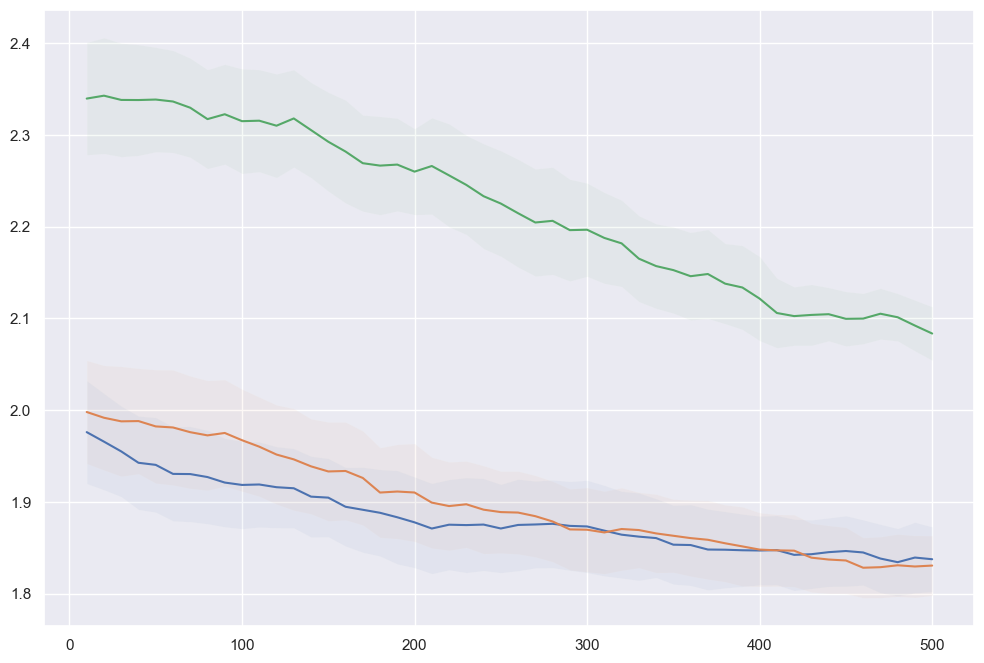

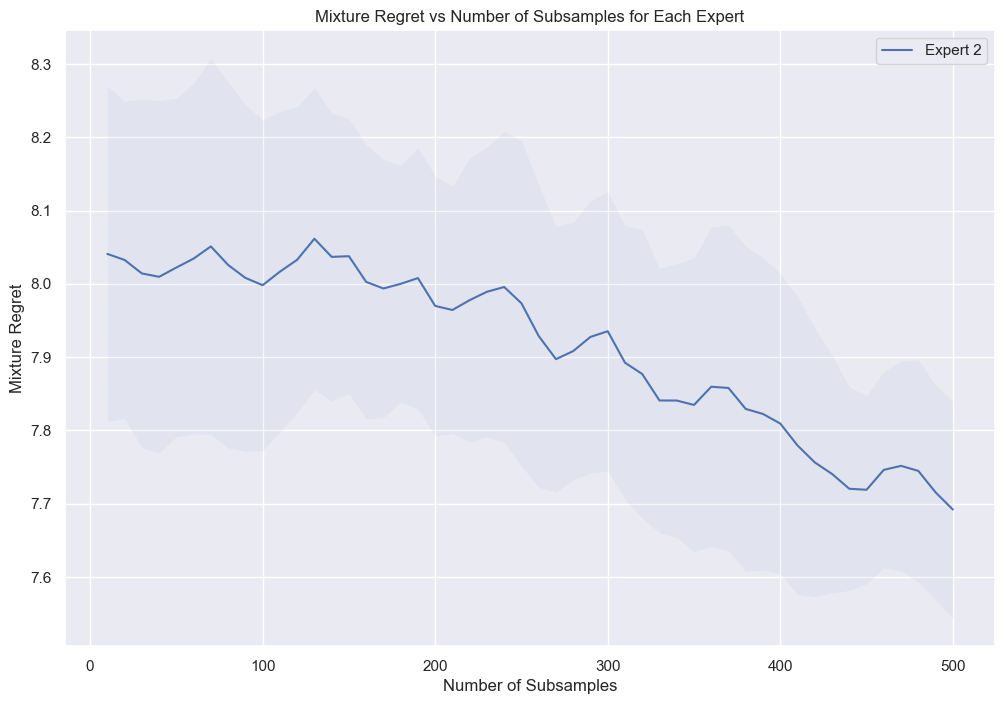

In [146]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# # Apply smoothing to the results
# plot_policy_values_dict = {}
# plot_best_policy_values_dict = {}
# plot_regret_values_dict = {}

# span = 50
# for source_id in range(2*NUM_SOURCES):
#     # plot_policy_values_dict[source_id] = smooth_values(policy_values_dict[source_id], span)
#     # plot_best_policy_values_dict[source_id] = smooth_values(best_policy_values_dict[source_id], span)
#     plot_regret_values_dict[source_id] = smooth_values(regret_values_dict[source_id], span)

# # Plot the results for each source_id
# plt.figure(figsize=(12, 8))

# for source_id in range(2*NUM_SOURCES):
#     # plt.plot(subsample_sizes, policy_values_dict[source_id], label=f'Source {source_id} Policy Value (Smoothed)', marker='o')
#     # plt.plot(subsample_sizes, best_policy_values_dict[source_id], label=f'Source {source_id} Best Policy Value (Smoothed)', marker='x')
#     plt.plot(subsample_sizes, plot_regret_values_dict[source_id], label=f'Source {source_id} Regret (Smoothed)', linestyle='-')

# plt.xlabel('Subsample Size')
# plt.ylabel('Value')
# plt.title('Smoothed Policy, Best Policy, and Regret over Different Subsample Sizes per Source')
# plt.legend()
# plt.grid(True)
# plt.show()


# Convert results to a DataFrame for easy plotting
results_df = pd.DataFrame(results, columns=['num_subsamples', 'expert_id', 'mean_regret', 'std_regret'])
mixture_results_df = pd.DataFrame(mixture_results, columns=['num_subsamples', 'mean_regret', 'std_regret'])

span = 20
# Plot the results with smoothing
plt.figure(figsize=(12, 8))
for expert_id in range(num_weights):
    # if expert_id not in [1, 4]: continue
    expert_data = results_df[results_df['expert_id'] == expert_id]
    # expert_data = mixture_results_df

    # Lowess smoothing
    res = smooth_values(expert_data['mean_regret'], span)
    # smoothed_x = lowess_smoothed[:, 0]
    # smoothed_y = lowess_smoothed[:, 1]

    # Plot the smoothed line
    plt.plot(subsample_sizes, res, label=f'Expert {expert_id}')

    # # Calculate and plot the standard deviation bands
    lowess_smoothed_std_upper = smooth_values(expert_data['mean_regret'] + expert_data['std_regret'], span)
    lowess_smoothed_std_lower = smooth_values(expert_data['mean_regret'] - expert_data['std_regret'], span)
    
    plt.fill_between(subsample_sizes, lowess_smoothed_std_lower, lowess_smoothed_std_upper, alpha=0.05)


plt.figure(figsize=(12, 8))
expert_data = mixture_results_df
# Lowess smoothing
res = smooth_values(expert_data['mean_regret'], span)
# smoothed_x = lowess_smoothed[:, 0]
# smoothed_y = lowess_smoothed[:, 1]

# Plot the smoothed line
plt.plot(subsample_sizes, res, label=f'Expert {expert_id}')

# # Calculate and plot the standard deviation bands
lowess_smoothed_std_upper = smooth_values(expert_data['mean_regret'] + expert_data['std_regret'], span)
lowess_smoothed_std_lower = smooth_values(expert_data['mean_regret'] - expert_data['std_regret'], span)

plt.fill_between(subsample_sizes, lowess_smoothed_std_lower, lowess_smoothed_std_upper, alpha=0.05)

# for source_id in range(NUM_SOURCES):
#     # plot_policy_values_dict[source_id] = smooth_values(policy_values_dict[source_id], span)
#     # plot_best_policy_values_dict[source_id] = smooth_values(best_policy_values_dict[source_id], span)
#     plot_regret_values_dict[source_id] = smooth_values(regret_values_dict[source_id], span)

#     plt.plot(subsample_sizes, plot_regret_values_dict[source_id], label=f'Source {source_id} Regret (Smoothed)', linestyle='--')

mean_regret = {source_id: np.mean(local_regret_values_dict[source_id], axis=0) for source_id in range(NUM_SOURCES)}
std_regret = {source_id: np.std(local_regret_values_dict[source_id], axis=0) for source_id in range(NUM_SOURCES)}

smooth_mean_regret = {source_id: smooth_values(mean_regret[source_id], span) for source_id in range(NUM_SOURCES)}
smooth_std_regret = {source_id: smooth_values(std_regret[source_id], span) for source_id in range(NUM_SOURCES)}

# plt.figure(figsize=(12, 8))

# for source_id in range(NUM_SOURCES):
#     plt.plot(subsample_sizes, smooth_mean_regret[source_id], label=f'Source {source_id} Mean Regret', linestyle='--')
#     plt.fill_between(subsample_sizes, 
#                      np.array(smooth_mean_regret[source_id]) - np.array(smooth_std_regret[source_id]),
#                      np.array(smooth_mean_regret[source_id]) + np.array(smooth_std_regret[source_id]), 
#                      alpha=0.05)

plt.xlabel('Number of Subsamples')
plt.ylabel('Mixture Regret')
plt.title('Mixture Regret vs Number of Subsamples for Each Expert')
plt.legend()
plt.show()

# Plot

INFO:matplotlib.mathtext:Substituting symbol S from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol S from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol S from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol S from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol S from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol S from STIXNonUnicode


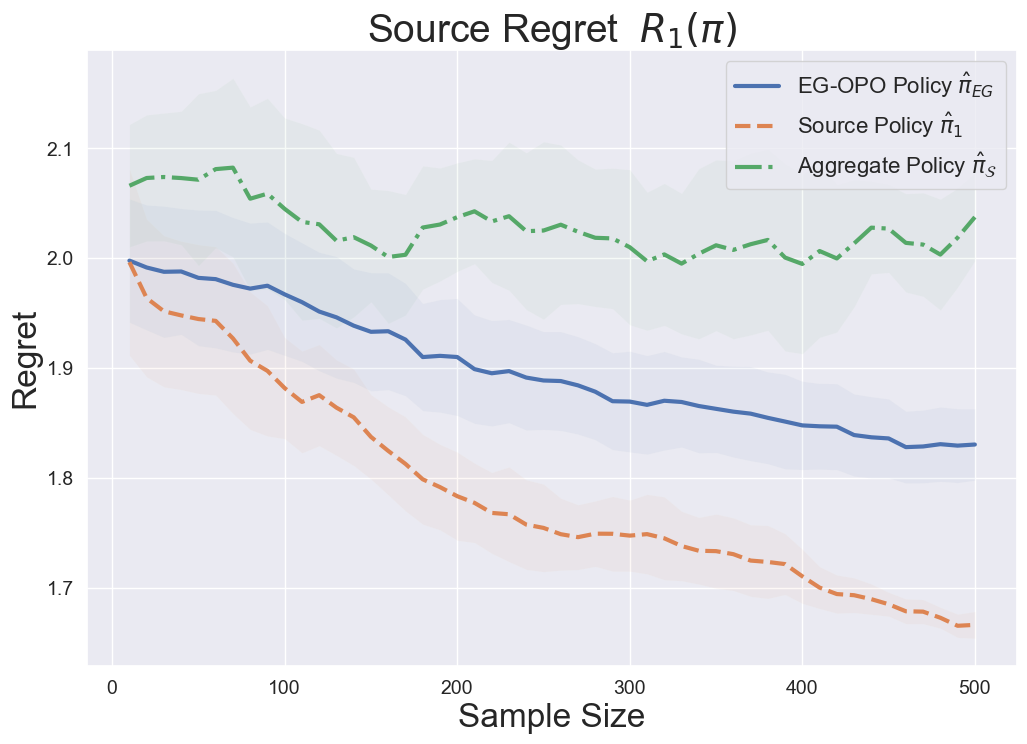

In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure necessary data (local_regret_values_dict, global_regret_values_dict, etc.) are defined before running

# Define smoothing function
def smooth_values(values, span):
    values_series = pd.Series(values)
    return values_series.rolling(window=span, min_periods=1, center=True).mean().tolist()

# Span for smoothing (adjust as needed)
span_local = 10
span_global = 10
span_expert = 20

# Allow plotting of a specific `source_id` or `expert_id`, or all of them
selected_source_id = 1  # Set to None to plot all, or a specific source_id (e.g., 0)
selected_expert_id = 1  # Set to None to plot all, or a specific expert_id (e.g., 1)

# ---- Local Plot Data ----
mean_regret_local = {source_id: np.mean(local_regret_values_dict[source_id], axis=0) for source_id in range(NUM_SOURCES)}
std_regret_local = {source_id: np.std(local_regret_values_dict[source_id], axis=0) for source_id in range(NUM_SOURCES)}
smooth_mean_regret_local = {source_id: smooth_values(mean_regret_local[source_id], span_local) for source_id in range(NUM_SOURCES)}
smooth_std_regret_local = {source_id: smooth_values(std_regret_local[source_id], span_local) for source_id in range(NUM_SOURCES)}

# ---- Global Plot Data ----
mean_regret_global = {source_id: np.mean(combined_regret_values_dict[source_id], axis=0) for source_id in range(NUM_SOURCES)}
std_regret_global = {source_id: np.std(combined_regret_values_dict[source_id], axis=0) for source_id in range(NUM_SOURCES)}
smooth_mean_regret_global = {source_id: smooth_values(mean_regret_global[source_id], span_global) for source_id in range(NUM_SOURCES)}
smooth_std_regret_global = {source_id: smooth_values(std_regret_global[source_id], span_global) for source_id in range(NUM_SOURCES)}

# ---- Expert Plot Data ----
results_df = pd.DataFrame(results, columns=['num_subsamples', 'expert_id', 'mean_regret', 'std_regret'])
mixture_results_df = pd.DataFrame(mixture_results, columns=['num_subsamples', 'mean_regret', 'std_regret'])

# Begin plotting all in a single figure
plt.figure(figsize=(12, 8))

# ---- Expert Plot ----
for expert_id in range(num_weights):
    if selected_expert_id is not None and expert_id != selected_expert_id:
        continue
    expert_data = results_df[results_df['expert_id'] == expert_id]
    
    # Lowess smoothing for expert data
    res = smooth_values(expert_data['mean_regret'], span_expert)
    
    # Plot the smoothed line for the expert
    plt.plot(expert_data['num_subsamples'], res, label=r'EG-OPO Policy $\hat{\pi}_{EG}$', linestyle='-', linewidth=3)

    # Calculate and plot the standard deviation bands
    lowess_smoothed_std_upper = smooth_values(expert_data['mean_regret'] + expert_data['std_regret'], span_expert)
    lowess_smoothed_std_lower = smooth_values(expert_data['mean_regret'] - expert_data['std_regret'], span_expert)
    plt.fill_between(expert_data['num_subsamples'], lowess_smoothed_std_lower, lowess_smoothed_std_upper, alpha=0.05)

# ---- Local Plot ----
for source_id in range(NUM_SOURCES):
    if selected_source_id is not None and source_id != selected_source_id:
        continue
    plt.plot(subsample_sizes, smooth_mean_regret_local[source_id], label=r'Source Policy $\hat{\pi}_1$', linestyle='--', linewidth=3)
    plt.fill_between(subsample_sizes, 
                     np.array(smooth_mean_regret_local[source_id]) - np.array(smooth_std_regret_local[source_id]),
                     np.array(smooth_mean_regret_local[source_id]) + np.array(smooth_std_regret_local[source_id]), 
                     alpha=0.05)

# ---- Global Plot ----
for source_id in range(NUM_SOURCES):
    if selected_source_id is not None and source_id != selected_source_id:
        continue
    plt.plot(subsample_sizes, smooth_mean_regret_global[source_id], label=r'Aggregate Policy $\hat{\pi}_{\mathcal{S}}$', linestyle='-.', linewidth=3)
    plt.fill_between(subsample_sizes, 
                     np.array(smooth_mean_regret_global[source_id]) - np.array(smooth_std_regret_global[source_id]),
                     np.array(smooth_mean_regret_global[source_id]) + np.array(smooth_std_regret_global[source_id]), 
                     alpha=0.05)


# ---- Finalize and Show Combined Plot ----
plt.xlabel('Sample Size', fontsize=24)
plt.ylabel(r'Regret', fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'Source Regret  $R_1(\pi)$', fontsize=28)
plt.legend(loc='upper right', fontsize=16)

plt.savefig('./img/source_regret.png', dpi=300)

plt.grid(True)
plt.show()


INFO:matplotlib.mathtext:Substituting symbol S from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol S from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol S from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol S from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol S from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol S from STIXNonUnicode


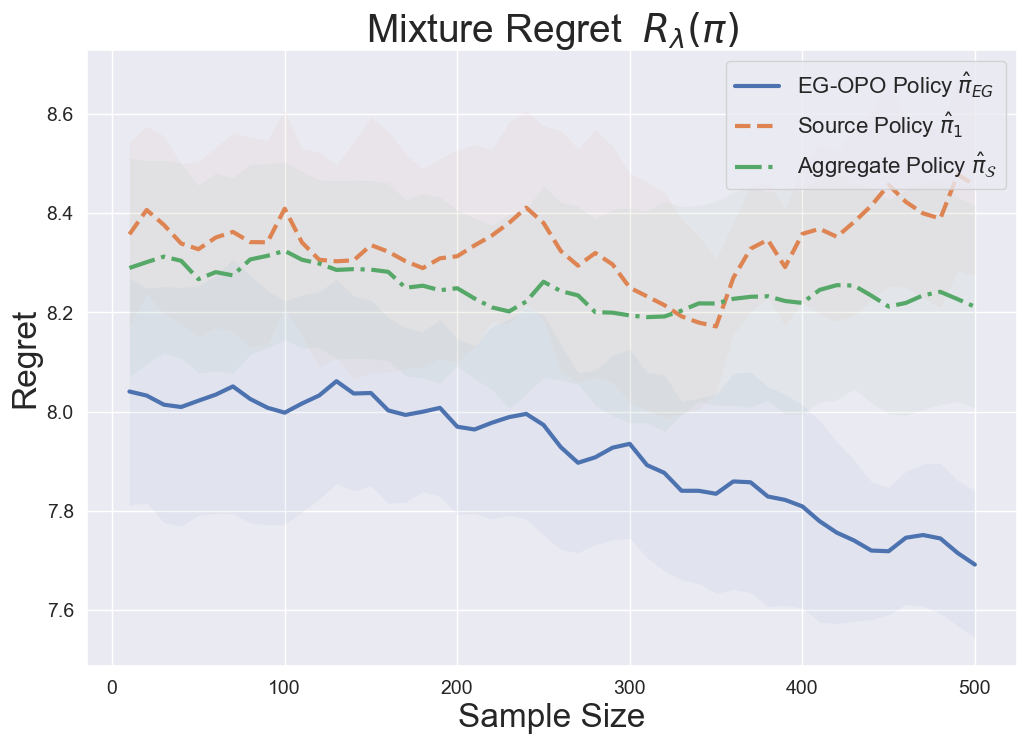

In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure necessary data (mixture_regret_values_dict, combined_mixture_regret_values, etc.) are defined before running

# Define smoothing function
def smooth_values(values, span):
    values_series = pd.Series(values)
    return values_series.rolling(window=span, min_periods=1, center=True).mean().tolist()

# Span for smoothing (adjust as needed)
span_local = 10
span_global = 20
span_expert = 20

# Allow plotting of a specific `source_id` or `expert_id`, or all of them
selected_source_id = 1  # Set to None to plot all, or a specific source_id (e.g., 0)
selected_expert_id = 1  # Set to None to plot all, or a specific expert_id (e.g., 1)

# Begin plotting all in a single figure
plt.figure(figsize=(12, 8))

# ---- Expert Plot ----
results_df = pd.DataFrame(results, columns=['num_subsamples', 'expert_id', 'mean_regret', 'std_regret'])
mixture_results_df = pd.DataFrame(mixture_results, columns=['num_subsamples', 'mean_regret', 'std_regret'])

expert_data = mixture_results_df

# Smoothing for expert data
res = smooth_values(expert_data['mean_regret'], span_expert)

# Plot the smoothed line for expert
plt.plot(expert_data['num_subsamples'], res, label=r'EG-OPO Policy $\hat{\pi}_{EG}$', linestyle='-', linewidth=3)

# Calculate and plot standard deviation bands
lowess_smoothed_std_upper = smooth_values(expert_data['mean_regret'] + expert_data['std_regret'], span_expert)
lowess_smoothed_std_lower = smooth_values(expert_data['mean_regret'] - expert_data['std_regret'], span_expert)
plt.fill_between(expert_data['num_subsamples'], lowess_smoothed_std_lower, lowess_smoothed_std_upper, alpha=0.05)

# ---- Local Plot ----
mean_regret_local = {source_id: np.mean(mixture_regret_values_dict[source_id], axis=0) for source_id in range(NUM_SOURCES)}
std_regret_local = {source_id: np.std(mixture_regret_values_dict[source_id], axis=0) for source_id in range(NUM_SOURCES)}
smooth_mean_regret_local = {source_id: smooth_values(mean_regret_local[source_id], span_local) for source_id in range(NUM_SOURCES)}
smooth_std_regret_local = {source_id: smooth_values(std_regret_local[source_id], span_local) for source_id in range(NUM_SOURCES)}

for source_id in range(NUM_SOURCES):
    if selected_source_id is not None and source_id != selected_source_id:
        continue
    plt.plot(subsample_sizes, smooth_mean_regret_local[source_id], label=r'Source Policy $\hat{\pi}_1$', linestyle='--', linewidth=3)
    plt.fill_between(subsample_sizes, 
                     np.array(smooth_mean_regret_local[source_id]) - np.array(smooth_std_regret_local[source_id]),
                     np.array(smooth_mean_regret_local[source_id]) + np.array(smooth_std_regret_local[source_id]), 
                     alpha=0.05)

# ---- Global Plot ----
mean_regret_global = np.mean(combined_mixture_regret_values, axis=0)
std_regret_global = np.std(combined_mixture_regret_values, axis=0)
smooth_mean_regret_global = smooth_values(mean_regret_global, span_global)
smooth_std_regret_global = smooth_values(std_regret_global, span_global)

plt.plot(subsample_sizes, smooth_mean_regret_global, label=r'Aggregate Policy $\hat{\pi}_{\mathcal{S}}$', linestyle='-.', linewidth=3)
plt.fill_between(subsample_sizes, 
                 np.array(smooth_mean_regret_global) - np.array(smooth_std_regret_global),
                 np.array(smooth_mean_regret_global) + np.array(smooth_std_regret_global), 
                 alpha=0.05)

# ---- Finalize and Show Combined Plot ----
plt.xlabel('Sample Size', fontsize=24)
plt.ylabel(r'Regret', fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'Mixture Regret  $R_\lambda(\pi)$', fontsize=28)
plt.legend(loc='upper right', fontsize=16)

plt.savefig('./img/mixture_regret.png', dpi=300)

plt.grid(True)
plt.show()
